# Importing packages

['../../Datasets/TransFociCub-allInOne/ns400nl5al3ac1-bug-chainSize-acf.parquet.brotli', '../../Datasets/TransFociCub-allInOne/ns400nl5al5ac1-bug-chainSize-acf.parquet.brotli', '../../Datasets/TransFociCub-allInOne/ns400nl5al1ac1-bug-chainSize.parquet.brotli', '../../Datasets/TransFociCub-allInOne/ns400nl5al3ac1-whole-equilProps.csv', '../../Datasets/TransFociCub-allInOne/ns400nl5al5ac1-whole-equilProps.csv', '../../Datasets/TransFociCub-allInOne/ns400nl5al1ac1-bug-chainSize-acf.parquet.brotli', '../../Datasets/TransFociCub-allInOne/ns400nl5al1ac1-whole-equilProps.csv', '../../Datasets/TransFociCub-allInOne/ns400nl5al5ac1-bug-chainSize.parquet.brotli', '../../Datasets/TransFociCub-allInOne/ns400nl5al3ac1-bug-chainSize.parquet.brotli']


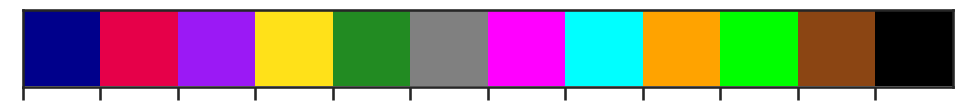

In [7]:
# Importing necessary packages:

from glob import glob
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
import itertools

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from polyphys.visualize import plotter
from polyphys.visualize.plotter import PROJECT_DETAILS as PD
from polyphys.visualize.plotter import PROPERTY_LABELS as PL
from polyphys.visualize.plotter import ATTRIBUTE_LABELS as AL
from polyphys.visualize.plotter import AMIRHSI_COLORS as AC
from polyphys.visualize.plotter import DUTCH_FEILD_COLORS as DF_colors
from polyphys.visualize import tuner
from polyphys.manage.parser import \
    SumRuleCyl, TransFociCyl, TransFociCub, HnsCub
from polyphys.manage import organizer
from polyphys.analyze import measurer
from polyphys.manage import utilizer

#import imageio
from matplotlib.image import NonUniformImage
from matplotlib.patches import Circle, Rectangle
from matplotlib import cm

# Project details
#project = 'HnsCub'
project = 'TransFociCub'
#project = 'SumRuleCyl'
#project = 'TransFociCub'
# loading databases:
allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
#allInOne_db = '/Users/amirhsi_mini/research_data/'+project+'/allInOne/' # relative
space_dbs = glob(allInOne_db + PD[project]['space_pat'])
print(space_dbs)
sns.palplot(AC)

In [ ]:
flar_cmap = mpl.colors.ListedColormap(sns.cm._flare_lut)
flare_cmap_cut = tuner.truncated_colormap(flar_cmap,  min_value=.1, max_value=1, ncolors=1000)
mpl.cm.register_cmap("flare_cmap_cut", flare_cmap_cut)

# Pair Distance Stats

### TransFociCyl: Importing dataset

In [8]:
pair_dist_properties = ['pairDistHistFoci', 'pairDistRdfFoci']
prop = pair_dist_properties[1]
# LOad data
dist_map = '-'.join(['allInOne', project, PD[project]['group'], 'pairDistStats.parquet.brotli'])
dist_map = allInOne_db + dist_map
dist_map = pd.read_parquet(dist_map)
# a sorted list of unique spaces in the dataset
spaces = dist_map['space'].unique()
spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
project_titles = {}
for space in spaces:
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    project_title_style = {
        #'SumRule': fr" $N={s_info.nmon}, {{D}}/{{a_m}}={s_info.dcyl}, {{a_c}}/{{a_m}}={s_info.dcrowd}$",
        #'TransFociCyl': fr" $N_m={s_info.nmon_small}, N_M={s_info.nmon_large}, {{D}}/{{a_m}}={s_info.dcyl}, {{a_c}}/{{a_m}}={s_info.dcrowd}$",
        'TransFociCub': fr" $N_m={s_info.nmon_small}, N_M={s_info.nmon_large}, {{a_c}}/{{a_m}}={s_info.dcrowd}$"
        }
    project_titles[project] = project_title_style[project]
# rounding phi_c as facgtors of 0.025:
# add rounded phi_crds to the dataset
divisor = 0.025
round_to = 3
dist_map['phi_c_bulk_round'] = dist_map['phi_c_bulk'].apply(
        utilizer.round_up_nearest, args=[divisor, round_to]
        )
# phi_c to drop
phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
dist_map = dist_map.loc[~dist_map['phi_c_bulk_round'].isin(phi_c_to_drop),:]
dist_map.reset_index(inplace=True, drop=True)
# Dropping pair distance cols of `prop_to_drop`
prop_to_drop = pair_dist_properties[0]
cols_to_drop = [col for col in dist_map.columns if col.startswith(prop_to_drop)]
dist_map.drop(columns=cols_to_drop, inplace=True)
dist_map['bin_center-norm-r-dmon_large'] = \
    dist_map['bin_center'] / dist_map['dmon_large']
dist_map['bin_center-norm'] = \
    dist_map['bin_center'] / dist_map['bin_center'].max()
# renaming pair distance cols of `prop`
pair_tags = {
    col: col.split('-')[1] for col in dist_map.columns if 'genDist' in col
    }
dist_map.rename(columns=pair_tags, inplace=True)
# Now, just keep the new col names for melting
pair_tags = list(pair_tags.values())
pair_names = {tag: organizer.sort_by_alphanumeric(tag)[1::2] for tag in pair_tags}
pair_names = {tag:
    r"$({0},{1},{2})$".format(int(locs[0]), int(locs[1]), int(locs[2])) for tag, locs in pair_names.items()}
attributes = PD[project]['equil_attributes'].copy()
attributes.extend(['bin_center', 'bin_center-norm', 'bin_center-norm-r-dmon_large'])
sel_cols = attributes + pair_tags
pair_dist = dist_map[sel_cols].melt(
    id_vars=attributes,
    value_vars=pair_tags,
    var_name=prop
)
pair_dist.loc[:, 'genomic_distance'] = pair_dist.loc[
    :, 'pairDistRdfFoci'].str.split(r'(\d+\.*\d*)', regex=True).apply(
    lambda str_list: int(float(str_list[-2])))

## Genomic position distance per d_mon

In [9]:
height = 4
aspect = 1
font_scale = 1
font_family = 'sans-serif' # 'Times New Roman'
plot_context = 'talk'
color_palette = 'colorblind'
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': False,
    'sharex': 'row',
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'markerscale': 1
}
bbox_global_set = dict(boxstyle="round,pad=0.05", edgecolor='white', color='white', alpha=0.7)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)

fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )

# Filter bin_Cetners based on rdf values
bin_center_cond = (pair_dist['bin_center-norm']<=0.3)
dmon_large_cond = (pair_dist['dmon_large'].isin([1,3,5]))
phi_c_cond = (pair_dist['phi_c_bulk_round'].isin([0, 0.1, 0.2, 0.3]))
conds = bin_center_cond & dmon_large_cond & phi_c_cond
data = pair_dist.loc[conds,:]
data.reset_index(inplace=True, drop=True)


x_prop = 'bin_center-norm-r-dmon_large'
y_prop = 'value'

col_attr = 'phi_c_bulk_round'
col_order = sorted(data[col_attr].unique())

row_attr = 'dmon_large'
row_order = sorted(data[row_attr].unique())

style_attr = 'genomic_distance'
style_order = sorted(data[style_attr].unique())

hue_attr = 'pairDistRdfFoci'
hue_order = sorted(data[hue_attr].unique(),key=organizer.sort_by_alphanumeric)
hue_labels = [pair_names[hue] for hue in hue_order]

tseries_grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    style=style_attr,
    style_order=style_order,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    legend='full',
    alpha=0.7,
    lw=2,
    errorbar=None,
    )
legend_labels = ['$(n_1, n_2,\Delta n)$'] + hue_labels +  [AL[style_attr]] + list(style_order)
for idx, new_label in enumerate(legend_labels):
    tseries_grid._legend.legendHandles[idx].set_linewidth(2)
    tseries_grid._legend.texts[idx].set_ha('left')
    tseries_grid._legend.texts[idx].set_text(new_label)
tseries_grid.set_ylabels(PL[project][hue_attr]['symbol'])
tseries_grid.set_xlabels(AL[x_prop])
for idx, dmon_large in enumerate(row_order):
    for ax in tseries_grid.axes[idx,:]:
        ax.axvline(1.0, label=r"$r=a_M$", lw=2, ls=':', color='black', zorder=0)
        vline_patch = tuner.ls_handler([r'$r=a_M$'], [':'], color='black', lw=2)
        ax.legend(
            handles=vline_patch,
            loc='upper right',
            **legend_kws
        )
tseries_grid.set_titles(
    AL[row_attr] + r"$={row_name}$, " + AL[col_attr] + r"$={col_name}$")
tseries_grid.fig.suptitle(project_titles[project], **fig_title_kws)
sns.move_legend(tseries_grid,
                loc='upper left',
                bbox_to_anchor=(0.82, 0.89),
                **legend_kws)
tseries_grid.tight_layout(w_pad=0.2, h_pad=0.1)
output = "-".join(
        ["equilPlot", project, 'pairDist', 'genomicPos']
    )
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
plt.close()

### Genomic distance matters not genomic position

In [10]:
bin_center_cond = (pair_dist['bin_center']<=20)
dmon_large_chosen =[5]
dmon_large_cond = (pair_dist['dmon_large'].isin(dmon_large_chosen))
phi_c_chosen = [0, 0.15, 0.3]
phi_c_cond = (pair_dist['phi_c_bulk_round'].isin(phi_c_chosen))
conds = bin_center_cond & dmon_large_cond & phi_c_cond
data = pair_dist.loc[conds,:]
data.reset_index(inplace=True, drop=True)

x_prop = 'bin_center-norm-r-dmon_large'
y_prop = 'value'

hue_attr = 'pairDistRdfFoci'
hue_order = sorted(data[hue_attr].unique(),key=organizer.sort_by_alphanumeric)
hue_labels = [pair_names[hue] for hue in hue_order]

col_attr = 'phi_c_bulk_round'
col_order = sorted(data[col_attr].unique())

row_attr = 'genomic_distance'
row_order = sorted(data[row_attr].unique())

tseries_grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    row=row_attr,
    row_order=row_order,
    col=col_attr,
    col_order=col_order,
    hue=hue_attr,
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    legend='full',
    alpha=0.7,
    ls='--',
    lw=2,
    errorbar=None,
    )
legend_labels = ['$(n_1, n_2,\Delta n)$'] + hue_labels
for idx, new_label in enumerate(legend_labels[1:]):
    tseries_grid._legend.legendHandles[idx].set_linewidth(2)
    tseries_grid._legend.texts[idx].set_ha('left')
    tseries_grid._legend.texts[idx].set_text(new_label)

for idx, dmon_large in enumerate(row_order):
    for ax in tseries_grid.axes[idx,:]:
        ax.axvline(1.0, label=r"$r=a_M$", lw=2, ls=':', color='black', alpha=0.8, zorder=1)
        vline_patch = tuner.ls_handler([r'$r=a_M$'], [':'], color='black', lw=2)
        ax.legend(
            handles=vline_patch,
            **legend_kws
        )
tseries_grid.set_ylabels(PL[project][hue_attr]['symbol'])
tseries_grid.set_xlabels(AL[x_prop])
#tseries_grid.set(xlim=(0,10), ylim=[0,0.75])
tseries_grid.set_titles(AL[row_attr] + r"$={row_name}$, " + AL[col_attr] + r"$={col_name}$")
tseries_grid.fig.suptitle(
    project_titles[project] + f", ${{a_M}}/{{a_m}}={dmon_large_chosen[0]}$", **fig_title_kws)
sns.move_legend(
    tseries_grid,
    title=legend_labels[0],
    loc='upper left',
    bbox_to_anchor=(0.74, 0.75),
    **legend_kws)
tseries_grid.tight_layout(w_pad=0, h_pad=0)
output = "-".join(
        ["equilPlot", project, 'pairDist', 'genomicDist', 'matters']
    )
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
plt.close()

### Genomic-distance-averaged data

##### Generating dataset

In [11]:
group_by_cols = pair_dist.columns.to_list()
group_by_cols.remove('value')
group_by_cols.remove('pairDistRdfFoci')
agg_dict = ['last'] * len(group_by_cols)
agg_dict = dict(zip(group_by_cols,agg_dict))
agg_dict['value'] = 'mean'
# averaging over genomic distance:
gen_dist = pair_dist.groupby(group_by_cols).agg(agg_dict)
gen_dist.reset_index(inplace=True, drop=True)
gen_dist.rename(columns={'value': 'pairDistRdfGenDistAvg'}, inplace=True)

##### Genomic distance explained

In [12]:
color_palette = AC
# Filter bin_Cetners based on rdf values
bin_center_cond = (gen_dist['bin_center-norm']<=0.4)
dmon_large_chosen = [1, 3, 5]
dmon_large_cond = (gen_dist['dmon_large'].isin(dmon_large_chosen))
phi_c_chosen = [0, 0.1, 0.3]
phic_cond = (gen_dist['phi_c_bulk_round'].isin(phi_c_chosen))
conds = dmon_large_cond & phic_cond & bin_center_cond
data = gen_dist.loc[conds,:]

x_prop = 'bin_center-norm'

y_prop = 'pairDistRdfGenDistAvg'

row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())

col_attr = 'dmon_large'
col_order = sorted(data[col_attr].unique())

style_attr = 'genomic_distance'
style_order = sorted(data[style_attr].unique())

hue_attr = 'dmon_large'
hue_order = sorted(data[hue_attr].unique())


sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )
tseries_grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    style=style_attr,
    style_order=style_order,
    hue=hue_attr,
    hue_order=hue_order,
    kind='line',
    height=height,
    aspect=aspect,
    legend='full',
    palette=color_palette,
    facet_kws=facet_kws,
    errorbar=None,
    lw=2
    )
legend_labels = [AL[hue_attr]] + hue_order + ['$\Delta n$'] + style_order
for idx, new_label in enumerate(legend_labels):
    tseries_grid._legend.legendHandles[idx].set_linewidth(2)
    tseries_grid._legend.texts[idx].set_ha('left')
    tseries_grid._legend.texts[idx].set_text(new_label)

tseries_grid.axes[0,-1].legend(
    handles=tseries_grid._legend.legendHandles[:len(hue_order)+1],
    labels=legend_labels[:len(hue_order)+1],
    loc='upper right',
    **legend_kws
)
tseries_grid.axes[1,-1].legend(
    handles=tseries_grid._legend.legendHandles[len(hue_order)+1:],
    labels=legend_labels[len(hue_order)+1:],
    **legend_kws
)
#legend_labels = [AL[hue_attr]] + list(col_order) +  [AL[size_attr]] + list(size_order)
#for idx, new_label in enumerate(legend_labels):
 #   tseries_grid._legend.texts[idx].set_text(new_label)

for idx, row in enumerate(row_order):
    data_row = gen_dist.loc[gen_dist[row_attr]==row,:]
    for idx_col, (ax, col) in enumerate(zip(tseries_grid.axes[idx,:], col_order)):
        bin_center_max = data_row.loc[data_row[col_attr]==col, 'bin_center'].max()
        y_max = data_row.loc[data_row[col_attr]==col, y_prop].max()
        dcrowd = data_row.loc[data_row[col_attr]==col, 'dcrowd'].unique()[0] # dcorwd is fixed here, so we use unique
        ax.set_ylim(0-0.04*y_max,y_max+0.04*y_max)
        ax.axvline(col / bin_center_max, label=r"$r=a_M$", lw=2, ls=':', color='black', zorder=0)
        x_range = np.linspace(0, (col+dcrowd)/bin_center_max,100)
        ax.fill_between(
            x_range, 1.05*y_max, 0,color='darkorchid', alpha=0.2, zorder=0, label='Direct contact'
        )
        fill_color_patch = tuner.color_handler(
            ['Direct contact'], ['darkorchid'], alpha=0.2
        )
        vl_patch = tuner.ls_handler([r'$r=a_M$'], [':'], color='black', lw=2)
        if (idx == 2) & (idx_col==2):
            ax.legend(handles=fill_color_patch+vl_patch,
                      loc='upper right',
                      **legend_kws
                     )
tseries_grid.set_ylabels(PL[project][y_prop]['symbol'])
tseries_grid.set_xlabels(AL[x_prop])
tseries_grid.set_titles(AL[row_attr] + r"$={row_name}$, " + AL[col_attr] + r"$={col_name}$")
tseries_grid.fig.suptitle(project_titles[project], **fig_title_kws)
tseries_grid.tight_layout(w_pad=0, h_pad=0)
tseries_grid._legend.remove()
output = "-".join(
        ["equilPlot", project, 'pairDist', 'genomicDist', 'explained']
    )
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
plt.close()

###### Line size not line style (not good)

In [ ]:
# Filter bin_Cetners based on rdf values
bin_center_cond = (gen_dist['bin_center-norm']<=0.4)
dmon_large_chosen = [1, 3, 5]
dmon_large_cond = (gen_dist['dmon_large'].isin(dmon_large_chosen))
phi_c_chosen = [0, 0.1, 0.3]
phic_cond = (gen_dist['phi_c_bulk_round'].isin(phi_c_chosen))
conds = dmon_large_cond & phic_cond & bin_center_cond
data = gen_dist.loc[conds,:]
ext = 'pdf'
save_to = './'
x_prop = 'bin_center-norm'

y_prop = 'pairDistRdfGenDistAvg'

row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())

col_attr = 'dmon_large'
col_order = sorted(data[col_attr].unique())

style_attr = 'genomic_distance'
style_order = sorted(data[style_attr].unique())

size_attr = 'genomic_distance'
size_order = sorted(data[size_attr].unique())
sizes=[3+2*i for i in range(len(size_order))]

hue_attr = 'dmon_large'
hue_order = sorted(data[hue_attr].unique())

sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )
tseries_grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    #style=style_attr,
    #style_order=style_order,
    size=size_attr,
    size_order=size_order,
    sizes=sizes,
    hue=hue_attr,
    hue_order=hue_order,
    kind='line',
    height=height,
    aspect=aspect,
    #dashes=True,
    #markers=True,
    legend='full',
    palette=color_palette,
    facet_kws=facet_kws,
    ci=None,
    markersize=15,
    markevery=5,
    ls="--"
    )
legend_labels = [AL[hue_attr]] + hue_order + ['$\Delta n$'] + size_order
for idx, new_label in enumerate(legend_labels):
    #tseries_grid._legend.legendHandles[idx].set_linewidth(7)
    tseries_grid._legend.texts[idx].set_ha('left')
    tseries_grid._legend.texts[idx].set_text(new_label)

tseries_grid.axes[0,0].legend(
    handles=tseries_grid._legend.legendHandles[:len(hue_order)+1],
    labels=legend_labels[:len(hue_order)+1],
    frameon=True,
    facecolor='lightgray',
    loc='upper right'
)
tseries_grid.axes[1,0].legend(
    handles=tseries_grid._legend.legendHandles[len(hue_order)+1:],
    labels=legend_labels[len(hue_order)+1:],
    frameon=True,
    facecolor='lightgray',
    markerscale=2
)
#legend_labels = [AL[hue_attr]] + list(col_order) +  [AL[size_attr]] + list(size_order)
#for idx, new_label in enumerate(legend_labels):
 #   tseries_grid._legend.texts[idx].set_text(new_label)

for idx, row in enumerate(row_order):
    data_row = gen_dist.loc[gen_dist[row_attr]==row,:]
    for idx_col, (ax, col) in enumerate(zip(tseries_grid.axes[idx,:], col_order)):
        bin_center_max = data_row.loc[data_row[col_attr]==col, 'bin_center'].max()
        ax.axvline(col / bin_center_max, label=r"$r=a_M$", lw=2, ls=':', color='black', zorder=0)
        vl_patch = tuner.ls_handler([r'$r=a_M$'], [':'], color='black', lw=6)
        if (idx == 2) & (idx_col==0):
            ax.legend(handles=vl_patch,
                      frameon=True,
                      facecolor='lightgray',
                      #loc='lower left',
                      #bbox_to_anchor=(0.565, 0.18)
                     )
tseries_grid.set_ylabels(PL[project][y_prop]['symbol'])
tseries_grid.set_xlabels(AL[x_prop])
tseries_grid.set_titles(AL[row_attr] + r"$={row_name}$ | " + AL[col_attr] + r"$={col_name}$")
tseries_grid.fig.suptitle(project_titles[project], **fig_title_kws)
tseries_grid.tight_layout(w_pad=0, h_pad=0)
tseries_grid._legend.remove()
#sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
output = "-".join(
        ["equilPlot", project, 'pairDist', 'genomicDist', 'explained']
    )
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
plt.close()

##### Genomic distance as col - nothing important

In [ ]:
# Filter bin_Cetners based on rdf values
bin_center_cond = (gen_dist['bin_center-norm']<=0.3)
dmon_large_chosen = [1, 3, 5]
dmon_large_cond = (gen_dist['dmon_large'].isin(dmon_large_chosen))
phi_c_chosen = [0.05, 0.2, 0.3,]
phic_cond = (gen_dist['phi_c_bulk_round'].isin(phi_c_chosen))
conds = dmon_large_cond & phic_cond & bin_center_cond
data = gen_dist.loc[conds,:]
data.reset_index(inplace=True, drop=True)

x_prop = 'bin_center-norm'
y_prop = 'pairDistRdfGenDistAvg'

hue_attr = 'dmon_large'
hue_order = sorted(data[hue_attr].unique())
color_palette = dmon_large_c_palette

col_attr = 'genomic_distance'
col_order = sorted(data[col_attr].unique())

row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())

ext = 'pdf'
save_to = './'
alpha = 0.7
height = 7
aspect = 1.618
plot_context = 'talk'
rc_params = {
        'mathtext.default': 'regular',
        'text.usetex': True
    }
save_to = './'
font_scale = 2
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}
move_legend_kws = {
    'bbox_to_anchor': (0.92, 0.5)
}
sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font='Times New Roman',
        font_scale=font_scale,
        rc=rc_params
    )
tseries_grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    alpha=alpha,
    errorbar=None,
    )
#for idx, new_label in enumerate(legend_labels[1:]):
#    tseries_grid._legend.texts[idx].set_text(new_label)
#tseries_grid.set_ylabels(properties_labels[project][hue_attr]['symbol'])
tseries_grid.set_xlabels(AL[x_prop])
tseries_grid.set_titles(
    AL[row_attr] + r"$={row_name}$" +
    " | " + AL[col_attr] + r"$={col_name}$"
    )
tseries_grid.legend.set_title(legend_labels[0])
tseries_grid.fig.suptitle(project_titles[project], **fig_title_kws)
tseries_grid.tight_layout(w_pad=1)
sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
output = "-".join(
        ["equilPlot", project, hue_attr, col_attr, row_attr, 'colStyle']
    )
tseries_grid.savefig(save_to + output + "-LessInfo." + ext, bbox_inches='tight')
plt.close()

### Pair Dist time-series per project: Not working

In [ ]:
prop = 'pairDistTFoci'
# Load data:
dist_tseries = '-'.join(['allInOne', project, group, 'pairDistT.parquet.brotli'])
dist_tseries = allInOne_db + dist_tseries
dist_tseries = pd.read_parquet(dist_tseries)
# a sorted list of unique spaces in the dataset
spaces = dist_tseries['space'].unique()
spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
project_titles = {}
for space in spaces:
    s_info = project_details[project]['parser'](
        space,
        geometry=geometry,
        group=group,
        lineage='space',
        ispath=False
    )
    project_title_style = {
        'SumRule': fr" $N={s_info.nmon}, D={s_info.dcyl}, a_c={s_info.dcrowd}$",
        'TransFoci': fr" $n_s={s_info.nmon_small}, n_l={s_info.nmon_large}, D={s_info.dcyl}, a_c={s_info.dcrowd}$"
        }
    project_titles[project] = project_title_style[project]
# rounding phi_c as facgtors of 0.025:
# add rounded phi_crds to the dataset
divisor = 0.025
round_to = 3
dist_tseries['phi_c_bulk_round'] = dist_tseries['phi_c_bulk'].apply(
        utilizer.round_up_nearest, args=[divisor, round_to]
        )
# phi_c to drop
phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
dist_tseries = dist_tseries.loc[~dist_tseries['phi_c_bulk_round'].isin(phi_c_to_drop),:]
dist_tseries.reset_index(inplace=True, drop=True)
# renaming pair distance cols of `prop`
pair_tags = {
    col: col.split('-')[1] for col in dist_tseries.columns if 'genDist' in col
    }
dist_tseries.rename(columns=pair_tags, inplace=True)
# Now, just keep the new col names for melting
pair_tags = list(pair_tags.values())
pair_names = [organizer.sort_by_alphanumeric(tag)[1::2] for tag in pair_tags]
pair_names = [
    r"$({0},{1},{2})$".format(int(locs[0]), int(locs[1]), int(locs[2])) for locs in pair_names]

In [ ]:
attributes = ['nmon_large','dmon_large', 'phi_c_bulk_round', 'time']
sel_cols = attributes + pair_tags
dist_tseries_melted = dist_tseries[sel_cols].melt(
    id_vars=attributes,
    value_vars=pair_tags,
    var_name=prop
)

In [ ]:
phi_c_chosen = [0., 0.2, 0.25, 0.3, 0.35, 0.4]
dist_tseries_melted_by_phi_c = dist_tseries_melted.loc[dist_tseries_melted['phi_c_bulk_round'].isin(phi_c_chosen),:]

legend_labels = ['$(n_1, n_2,\Delta n)$'] + pair_names
x_prop = 'time'
y_prop = 'value'
hue_attr = 'pairDistTFoci'
col_attr = 'dmon_large'
row_attr = 'phi_c_bulk_round'
color_palette = 'colorblind'
alpha = 0.7
height = 6
aspect = 1.618
plot_context = 'talk'
rc_params = {
        'mathtext.default': 'regular',
        'text.usetex': True
    }
save_to = './'
font_scale = 2
facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}
move_legend_kws = {
    'bbox_to_anchor': (0.91, 0.5)
}

plotter.p_pairDist_allInOne_project_colStyle(
    dist_tseries_melted_by_phi_c,
    project,
    project_title_style[project],
    x_prop,
    y_prop,
    hue_attr,
    col_attr,
    row_attr,
    project_details[project],
    AL,
    legend_labels,
    height=height,
    aspect=aspect,  # golden ratio
    color_palette=color_palette,
    plot_context=plot_context,
    rc_params=rc_params,
    font_scale=font_scale,
    save_to=save_to,
    facet_kws=facet_kws,
    alpha=alpha,
    move_legend_kws=move_legend_kws
)

In [ ]:
phi_c_chosen = [0.25, 0.275, 0.3, 0.325, 0.35]
phi_c_chosen = [0.25, 0.3, 0.35]
phi_cond = (dist_tseries_melted['phi_c_bulk_round'].isin(phi_c_chosen))
dmon_large_chosen = 5.0
dmon_larg_cond = (dist_tseries_melted['dmon_large']==dmon_large_chosen)
dist_tseries_melted_by_phi_c_dmon_large = dist_tseries_melted.loc[phi_cond & dmon_larg_cond,:]

legend_labels = ['$(n_1, n_2,\Delta n)$'] + pair_names
x_prop = 'time'
y_prop = 'value'
col_attr = 'pairDistTFoci'
color_palette = 'Set2'
hue_attr = 'phi_c_bulk_round'
alpha = 0.7
height = 6
aspect = 1.618
plot_context = 'talk'
rc_params = {
        'mathtext.default': 'regular',
        'text.usetex': True
    }
save_to = './'
font_scale = 2
facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}
move_legend_kws = {
    'bbox_to_anchor': (0.91, 0.5)
}
ext = 'pdf'
col_wrap=3
save_to = './'
axes_style = 'ticks'
font_family = 'Times New Roman'
fig_title_kw = {'x': 0.5, 'y': 1.0}
sns.set_theme(
        context=plot_context,
        style=axes_style,
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )
tseries_grid = sns.relplot(
    data=dist_tseries_melted_by_phi_c_dmon_large,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_wrap=col_wrap,
    hue=hue_attr,
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    alpha=alpha,
    ci=None
)
for ax, pair_name in zip(tseries_grid.axes.flat, pair_names):
        ax.set_title('$(n_1, n_2,\Delta n)=$' + pair_name)
tseries_grid.set_ylabels(norm_props_specs[project][col_attr]['symbol'])
tseries_grid.set_xlabels(AL[x_prop])
tseries_grid.legend.set_title(AL[hue_attr])
sns.move_legend(tseries_grid, "upper left", bbox_to_anchor=(.35, .25), frameon=False)
tseries_grid.fig.suptitle(project_title_style[project], **fig_title_kw)
tseries_grid.tight_layout(w_pad=0)
output = "-".join(
    ["equilPlot", col_attr, hue_attr, 'al'+str(dmon_large_chosen), 'phic' + str(len(phi_c_chosen))]
)
tseries_grid.savefig(save_to + output + "." + ext, bbox_inches='tight')
plt.close()

# Local spatial distributions:

## Not working: Different plotting styles for different projects

### Sum-rule  project

In [ ]:
directions = ['z', 'r']
props = ['Phi', 'Rho']
dir_prop_pairs = list(itertools.product(directions, props))

species_list = ['Mon', 'Crd']
species_names = ['Monomers', 'Crowders']
species_names_dict = dict(zip(species_list, species_names))

#allInOne_db = '/Users/amirhsi_mini/research_data/analysis/'
allInOne_db = '/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets/SumRuleCyl-allInOne/'
group = 'all'
geometry = 'biaxial'
for direction, prop in dir_prop_pairs[:1]:
    prop_fullname = direction + prop
    equil_db = '-'.join(
        ['allInOne', project, group, direction + 'LocalDist.parquet.brotli']
    )
    equil_db = allInOne_db + equil_db
    local_dist = pd.read_parquet(equil_db)
    # dropping extra columns
    redundants = [
        'HistCrd-mean', 'HistCrd-var', 'HistCrd-sem', 'HistCrd-norm',
        'HistMon-mean', 'HistMon-var', 'HistMon-sem', 'HistMon-norm',
        'PhiCrd-var', 'PhiCrd-sem', 'PhiMon-var', 'PhiMon-sem',
        'RhoCrd-var','RhoCrd-sem', 'RhoMon-var', 'RhoMon-sem'
    ]
    cols_to_drop = [direction + col for col in redundants]
    local_dist.drop(columns=cols_to_drop, inplace=True)
    # dropping crowders distributions with phi_c=0
    local_phi_c_cond = \
        (local_dist['phi_c_bulk_round'] == 0) & (local_dist[direction + prop +'Crd-mean'] == 0)
    local_dist = local_dist.loc[~local_phi_c_cond,:]
    # melting based on species:
    attributes = project_details[project]['equil_attributes'].copy()
    attributes = attributes + ['bin_center', 'bin_center-norm']
    hist_cols = list(set(local_dist.columns).difference(set(attributes)))
    hist_cols_norm = [col for col in hist_cols if col.endswith('norm')]
    prop_cols_norm = [col for col in hist_cols_norm if prop in col]
    sel_cols_norm = attributes + prop_cols_norm
    local_prop_norm = local_dist[sel_cols_norm].melt(
        id_vars=attributes,
        value_vars=prop_cols_norm,
        var_name=prop_fullname
    )
    # prop_fullname
    local_prop_norm.loc[:, prop_fullname] = \
        local_prop_norm.loc[:, prop_fullname].apply(
            lambda x: x.split('-')[0].split(prop_fullname)[-1]
    )
    local_prop_norm.loc[:, prop_fullname] = \
        local_prop_norm.loc[:, prop_fullname].apply(
            lambda x: species_names_dict[x]
    )
    # plotting style
    ext = 'pdf'
    save_to = './'

    data = local_prop_norm

    x_prop = 'bin_center-norm'
    x_prop_name = 'bin_center-norm' + '-' + direction
    y_prop = 'value'

    style_attr = 'dcyl'
    style_order = data[style_attr].unique()
    style_order.sort()

    hue_attr = 'phi_c_bulk_round'
    hue_order = data[hue_attr].unique()
    hue_order.sort()

    row_attr = 'dcrowd'
    row_order = data[row_attr].unique()
    row_order.sort()

    col_attr = prop_fullname
    col_order = species_names

    size_attr = 'nmon'
    size_order = data[size_attr].unique()
    size_order.sort()

    color_palette = 'rocket_r'
    height = 7
    aspect = 1.618
    plot_context = 'talk'
    rc_params = {
            'mathtext.default': 'regular',
            'text.usetex': True
        }
    save_to = './'
    font_scale = 2.5
    fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
    facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}
    move_legend_kws = {'bbox_to_anchor': (0.8, 1.0)}
    sns.set_theme(
            context=plot_context,
            style='ticks',
            palette=color_palette,
            font='Times New Roman',
            font_scale=font_scale,
            rc=rc_params
        )
    tseries_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        style=style_attr,
        style_order=style_order,
        size=size_attr,
        size_order=size_order,
        col=col_attr,
        col_order=col_order,
        row=row_attr,
        row_order=row_order,
        hue=hue_attr,
        hue_order=hue_order,
        marker=True,
        markevery=7,
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        alpha=0.7,
        lw=4,
        ci=None,
        )
    legend_labels =  [AL[hue_attr]] + list(hue_order) +  [AL[size_attr]] + list(size_order) + [AL[style_attr]] + list(style_order)
    for idx, new_label in enumerate(legend_labels):
        tseries_grid._legend.texts[idx].set_text(new_label)
    tseries_grid.set_ylabels(properties_labels[project][prop_fullname+'-norm']['symbol'])
    tseries_grid.set_xlabels(AL[x_prop_name])
    tseries_grid.set_titles(
        "{col_name} | " + AL[row_attr] + r"$={row_name}$"
    )
    tseries_grid.tight_layout(w_pad=1)
    sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
    output = "-".join(["equilPlot", project, prop_fullname, 'LocalDist'])
    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

### Trans-Foci project

In [ ]:
directions = ['z', 'r']
props = ['Phi', 'Rho']
species_list = ['Foci', 'Mon', 'Crd']
species_names = ['Big monomers', 'Small monomers', 'Crowders']
species_names_dict = dict(zip(species_list, species_names))
dir_prop_pairs = list(itertools.product(directions, props))
allInOne_db = '/Users/amirhsi_mini/research_data/analysis/'
group = 'all'
geometry = 'biaxial'
for direction, prop in dir_prop_pairs:
    prop_fullname = direction + prop
    equil_db = '-'.join(
        ['allInOne', project, group, direction + 'LocalDist.parquet.brotli']
    )
    equil_db = allInOne_db + equil_db
    local_dist = pd.read_parquet(equil_db)
    # dropping extra columns
    redundants = [
        'HistCrd-mean', 'HistCrd-var', 'HistCrd-sem', 'HistCrd-norm',
        'HistMon-mean', 'HistMon-var', 'HistMon-sem', 'HistMon-norm',
        'PhiCrd-var', 'PhiCrd-sem', 'PhiMon-var', 'PhiMon-sem',
        'RhoCrd-var','RhoCrd-sem', 'RhoMon-var', 'RhoMon-sem'
    ]
    cols_to_drop = [direction + col for col in redundants]
    local_dist.drop(columns=cols_to_drop, inplace=True)
    # dropping crowders distributions with phi_c=0
    local_phi_c_cond = \
        (local_dist['phi_c_bulk_round'] == 0) & (local_dist[direction + prop +'Crd-mean'] == 0)
    local_dist = local_dist.loc[~local_phi_c_cond,:]
    # melting based on species:
    attributes = project_details[project]['equil_attributes'].copy()
    attributes = attributes + ['bin_center', 'bin_center-norm']
    hist_cols = list(set(local_dist.columns).difference(set(attributes)))
    hist_cols_norm = [col for col in hist_cols if col.endswith('norm')]
    prop_cols_norm = [col for col in hist_cols_norm if prop in col]
    sel_cols_norm = attributes + prop_cols_norm
    local_prop_norm = local_dist[sel_cols_norm].melt(
        id_vars=attributes,
        value_vars=prop_cols_norm,
        var_name=prop_fullname
    )
    # prop_fullname
    local_prop_norm.loc[:, prop_fullname] = \
        local_prop_norm.loc[:, prop_fullname].apply(
            lambda x: x.split('-')[0].split(prop_fullname)[-1]
    )
    local_prop_norm.loc[:, prop_fullname] = \
        local_prop_norm.loc[:, prop_fullname].apply(
            lambda x: species_names_dict[x]
    )
    # plotting style
    #species_order = [prop_fullname + species + '-norm' for species in species_list]
    ext = 'pdf'
    save_to = './'

    data = local_prop_norm

    species_legend = ['Particle type'] + species_names

    x_prop = 'bin_center-norm'
    x_prop_name = 'bin_center-norm' + '-' + direction
    y_prop = 'value'


    hue_attr = 'phi_c_bulk_round'
    hue_order = data[hue_attr].unique()
    hue_order.sort()

    col_attr = 'dmon_large'
    col_order = data[col_attr].unique()
    col_order.sort()

    row_attr = prop_fullname
    row_order = species_names

    color_palette = 'rocket_r'
    height = 7
    aspect = 1.618
    plot_context = 'talk'
    rc_params = {
            'mathtext.default': 'regular',
            'text.usetex': True
        }
    save_to = './'
    font_scale = 2.5
    fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
    facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}
    move_legend_kws = {'bbox_to_anchor': (0.85, 0.9)}
    sns.set_theme(
            context=plot_context,
            style='ticks',
            palette=color_palette,
            font='Times New Roman',
            font_scale=font_scale,
            rc=rc_params
        )
    tseries_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        col=col_attr,
        col_order=col_order,
        row=row_attr,
        row_order=row_order,
        hue=hue_attr,
        hue_order=hue_order,
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        alpha=0.7,
        lw=4,
        ci=None,
        )
    legend_labels = [AL[hue_attr]] + list(hue_order) + species_legend
    for idx, new_label in enumerate(legend_labels):
        tseries_grid._legend.texts[idx].set_text(new_label)
    tseries_grid.set_ylabels(properties_labels[project][prop_fullname+'-norm']['symbol'])
    tseries_grid.set_xlabels(AL[x_prop_name])
    tseries_grid.set_titles("{row_name} | " + AL[col_attr] + r"$={col_name}$")
    tseries_grid.tight_layout(w_pad=1)
    sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
    output = "-".join(["equilPlot", project, prop_fullname, 'LocalDist'])
    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

## **SumRuleCyl**  project

#### Import averaged chain size measures and merging it with systems

In [ ]:
phase = 'ensAvg'
equil_db = '-'.join(
    ['allInOne', project, PD[project]['group'], 'equilProps', phase]
)
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)

### Meging different distributions along different directions

In [ ]:
group = 'all'
directions = ['r','z']
props = ['Phi', 'Rho']
dir_prop_pairs = list(itertools.product(directions, props))
species_list = ['Mon', 'Crd']
normalizing_methods = ['norm', 'scale-normalized_curve']
# 'norm': normalizing each curve with its deeip inside species-rich region
# 'scale-normalized_curve': normalizing each curve to make the area-under-cruve 1.
species_names = ['Chain', 'Crowders']
species_names_dict = dict(zip(species_list, species_names))
species_names_dict['Sum'] = 'Sum'
# col to drops for each prop
measures = ['mean','sem', 'var']
ens_avg_measures = [s + '-' + col for s in species_list for col in measures]
group = 'all'
geometry = 'cylindrical'
var_cols = []
dist = []
for normalizing_method in normalizing_methods:
    dist_per_norm = []
    melting_dict = [s + '-' + normalizing_method for s in species_list]
    melting_dict.append('Sum-sumrule_local')
    for direction, prop in dir_prop_pairs:
        p_name = direction + prop
        equil_db = '-'.join(
            ['allInOne', project, group, p_name]
        )
        equil_db += '-NormalizedScaled.parquet.brotli'
        equil_db = allInOne_db + equil_db
        local_dist = pd.read_parquet(equil_db)
        # add a column for crowder relative size
        dmon = 1.0
        local_dist['size_ratio'] = local_dist['dcrowd'].apply(lambda x: r"$a_c<a$" if x < dmon else (r"$a_c=a$"  if x==dmon else r"$a_c>a$"))
        # norming z values by mean fsd of mon
        # no change for r direction
        local_dist['bin_center-fsd_mean'] = local_dist['bin_center-norm']
        # fsd for z direction:
        if direction == 'z':
            ensembles = local_dist['ensemble_long'].unique()
            for ens in ensembles:
                ens_cond_eq = chainsize_equil['ensemble_long']== ens
                ens_cond = local_dist['ensemble_long']== ens
                fsd_mean = \
                    chainsize_equil.loc[ens_cond_eq, 'fsdMon-mean'].values[0]
                local_dist.loc[ens_cond, 'bin_center-fsd_mean'] = local_dist.loc[ens_cond, 'bin_center'] / (0.5*fsd_mean)
        # Dropping redundant columns
        cols_to_drop = [p_name + redund for redund in ens_avg_measures]
        local_dist.drop(columns=cols_to_drop, inplace=True)
        # Sumrule at local level
        local_dist[p_name+'Sum-sumrule_local'] = 0
        local_dist[p_name+'Sum-sumrule_constant'] = 0
        for s in species_list:
            local_dist[p_name+'Sum-sumrule_local'] += \
                local_dist[p_name+s+'-scale']
        local_dist[p_name+'Sum-sumrule_local'] = \
            (local_dist[p_name+'Sum-sumrule_local'] /
             local_dist[p_name+'Crd-normalizer'])
        # Melting based local distributions on species:
        attributes = PD[project]['equil_attributes'].copy()
        attributes += ['bin_center', 'bin_center-norm', 'bin_center-dcrowd', 'bin_center-dcrowd-recentered', 'bin_center-fsd_mean']
        var_name =  'species'
        var_cols = [p_name + col for col in melting_dict]
        sel_cols = attributes + var_cols
        local_dist_melted = local_dist[sel_cols].melt(
            id_vars=attributes,
            value_vars=var_cols,
            value_name=normalizing_method+'_'+var_name+'_value',
            var_name=var_name
        )
        # Renaming values
        local_dist_melted.loc[:, var_name] = \
            local_dist_melted.loc[:, var_name].apply(
                lambda x: x.split('-')[0].split(p_name)[-1]
            )
        local_dist_melted.loc[:, var_name] = \
            local_dist_melted.loc[:, var_name].apply(
                lambda x: species_names_dict[x]
        )
        # local_dist_melted
        local_dist_melted['direction'] = direction
        local_dist_melted['property'] = prop
        dist_per_norm.append(local_dist_melted)
    dist_per_norm = pd.concat(dist_per_norm, axis=0)
    dist_per_norm.reset_index(inplace=True, drop=True)
    dist_per_norm.drop(columns=['ensemble', 'space', 'ensemble_long'], inplace=True)
    dist.append(dist_per_norm)
dist = pd.concat(dist, axis=1)
dist.reset_index(inplace=True, drop=True)
dist = dist.loc[:, ~dist.columns.duplicated()].copy()
# Dropping distributions with phi_c=0
dist_without_phic0 = dist[dist['phi_c_bulk_round']!=0]
# unique systems
dist_without_phic0.reset_index(inplace=True, drop=True)
systems = dist.groupby(['nmon','dcyl','dcrowd','phi_c_bulk_round','direction','property'], as_index=False)['bin_center'].max()
# unique chains
chains = dist[['nmon','dcyl','dcrowd']].drop_duplicates()
chains.sort_values(by=['nmon','dcyl','dcrowd'], inplace=True)
chains.reset_index(inplace=True, drop=True)
systems_wtih_equils = systems.merge(chainsize_equil, how='left')
del directions, props, dir_prop_pairs, species_list, normalizing_methods
del normalizing_method, melting_dict, species_names, species_names_dict
del measures, ens_avg_measures, allInOne_db, group, geometry, var_cols, prop
del direction, local_dist, local_dist_melted, var_name,  attributes, sel_cols

### Sum rule alone: incomplete plot

In [ ]:
# Filtering dataset
for direction in ['z','r']:
    property_ = 'Phi'
    var_col_cond = (dist['species'].isin(['Sum']))
    prop_cond = (dist['property'].isin([property_]))
    dir_cond = (dist['direction'].isin([direction]))
    cond = var_col_cond & dir_cond & prop_cond
    data = dist_without_phic0.loc[cond, :].copy()
    data.reset_index(inplace=True, drop=True)
    # Rescaling bin centers by crowder size

    data['confinement_rate'] = np.round(
        (data['dcrowd'])/
         (data['dcyl'] - data['dcrowd']), 3)
    data['confinement_rate_r'] = np.round(
         (data['dcyl'] - data['dcrowd'])/(data['dcrowd']), 3)
    data['dep_energy_max'] = np.round(
        data['phi_c_bulk_round'] * (1 +
        (3 * 1.0) / (2 * data['dcrowd'])
        ),3)
    data['int_energy_max'] = np.round(
        data['nmon'] * data['phi_c_bulk_round'] * (
        1.0 / data['dcrowd']) * ( 3 * 1.0 * data['dcrowd'] + 3/2), 3)
    # phi_c_rescaled = dmon * phi_c_bulk / dcrowd
    data['phi_c_rescaled'] = np.round(
        1.0 * data['phi_c_bulk'] / data['dcrowd'],
        3
    )
    # plotting style

    ext = 'pdf'
    save_to = './'

    x_prop = 'bin_center-norm'
    x_prop_name = x_prop + '-' + direction
    y_prop = 'norm_species_value'

    col_attr = 'phi_c_bulk_round'
    col_order = sorted(data[col_attr].unique())

    style_attr = 'nmon'
    style_order = sorted(data[style_attr].unique())

    size_attr = 'dcyl'
    size_order = sorted(data[size_attr].unique())
    sizes=[3+2*i for i in range(len(size_order))]

    hue_attr = 'dcrowd'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = sns.color_palette("rocket_r", len(hue_order))

    height = 9
    aspect = 1.618
    plot_context = 'talk'
    rc_params = {
        'axes.facecolor': 'aliceblue',
        'mathtext.default': 'regular',
        'text.usetex': True,
        'axes.grid': True,
        'axes.grid.axis': 'both',
        #'axes.grid.which': 'both'
        }
    save_to = './'
    font_scale = 3
    fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
    facet_kws = {'sharey': False, 'sharex': False, 'legend_out': True}
    move_legend_kws = {
        'ncol': 1,
        'bbox_to_anchor': (1, 0.98),
        'frameon': True,
        'facecolor': 'aliceblue',
        'borderpad': 0.1,
        'markerscale': 3
    }
    sns.set_theme(
            context=plot_context,
            style='ticks',
            palette=color_palette,
            font='Times New Roman',
            font_scale=font_scale,
            rc=rc_params
        )
    if direction == 'r':
        markevery = 4
    else:
        markevery = 15
    tseries_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        style=style_attr,
        style_order=style_order,
        size=size_attr,
        size_order=size_order,
        sizes=sizes,
        col=col_attr,
        col_order=col_order,
        col_wrap=3,
        hue=hue_attr,
        hue_order=hue_order,
        markers=True,
        dashes=False ,
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        markersize=20,
        markevery=markevery,
        alpha=0.7,
        lw=4,
        errorbar=None,
        )
    legend_labels = ([AL[hue_attr+'-'+project]] + list(hue_order) + \
                     [AL[size_attr]] + list(size_order) + \
                     [AL[style_attr]] + list(style_order)
                    )
    for idx, new_label in enumerate(legend_labels):
        #tseries_grid._legend.legendHandles[idx].set_linewidth(7)
        tseries_grid._legend.texts[idx].set_ha('left')
        tseries_grid._legend.texts[idx].set_text(new_label)

    tseries_grid.set_xlabels(AL[x_prop_name])
    tseries_grid.set_ylabels(PL[project][direction+property_+'-norm']['Sum'])
    tseries_grid.set_titles(AL[col_attr] + r"$={col_name}$")
    if direction == 'z':
        tseries_grid.set(xlim=(0-0.02,0.5+0.02),xticks=np.arange(0,0.6,0.1))
    else:
        tseries_grid.set(xlim=(0-0.02,1.0+0.02),xticks=np.arange(0,1.2,0.2))
    sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
    tseries_grid.fig.tight_layout(pad=0)
    output = "-".join(
        ["equilPlot", project, direction + property_, col_attr, hue_attr, style_attr, size_attr, 'SumRuleEquationAlone']
    )
    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

### Sum rule alone: a_c=4, 6 ignored:  incomplete plot incomplete plot

In [ ]:
# Filtering dataset
for direction in ['z', 'r']:
    property_ = 'Phi'
    dcrowd_cond = (dist['dcrowd'].isin([4.0,6.0]))
    var_col_cond = (dist['species'].isin(['Sum']))
    prop_cond = (dist['property'].isin([property_]))
    dir_cond = (dist['direction'].isin([direction]))
    cond = var_col_cond & dir_cond & prop_cond & ~dcrowd_cond
    data = dist.loc[cond, :].copy()
    data.reset_index(inplace=True, drop=True)
    # Rescaling bin centers by crowder size

    data['confinement_rate'] = np.round(
        (data['dcrowd'])/
         (data['dcyl'] - data['dcrowd']), 3)
    data['confinement_rate_r'] = np.round(
         (data['dcyl'] - data['dcrowd'])/(data['dcrowd']), 3)
    data['dep_energy_max'] = np.round(
        data['phi_c_bulk_round'] * (1 +
        (3 * 1.0) / (2 * data['dcrowd'])
        ),3)
    data['int_energy_max'] = np.round(
        data['nmon'] * data['phi_c_bulk_round'] * (
        1.0 / data['dcrowd']) * ( 3 * 1.0 * data['dcrowd'] + 3/2), 3)
    # phi_c_rescaled = dmon * phi_c_bulk / dcrowd
    data['phi_c_rescaled'] = np.round(
        1.0 * data['phi_c_bulk'] / data['dcrowd'],
        3
    )
    # plotting style

    ext = 'pdf'
    save_to = './'

    x_prop = 'bin_center-norm'
    x_prop_name = x_prop + '-' + direction
    y_prop = 'norm_species_value'

    col_attr = 'phi_c_bulk_round'
    col_order = sorted(data[col_attr].unique())

    style_attr = 'nmon'
    style_order = sorted(data[style_attr].unique())

    size_attr = 'dcyl'
    size_order = sorted(data[size_attr].unique())
    sizes=[3+2*i for i in range(len(size_order))]

    hue_attr = 'dcrowd'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = sns.color_palette("rocket_r", len(hue_order))

    height = 9
    aspect = 1.618
    plot_context = 'talk'
    rc_params = {
        'axes.facecolor': 'aliceblue',
        'mathtext.default': 'regular',
        'text.usetex': True,
        'axes.grid': True,
        'axes.grid.axis': 'both',
        #'axes.grid.which': 'both'
        }
    save_to = './'
    font_scale = 3
    fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
    facet_kws = {'sharey': False, 'sharex': False, 'legend_out': True}
    move_legend_kws = {
        'ncol': 1,
        'bbox_to_anchor': (1, 0.98),
        'frameon': True,
        'facecolor': 'aliceblue',
        'borderpad': 0.1,
        'markerscale': 3
    }
    sns.set_theme(
            context=plot_context,
            style='ticks',
            palette=color_palette,
            font='Times New Roman',
            font_scale=font_scale,
            rc=rc_params
        )
    if direction == 'r':
        markevery = 4
    else:
        markevery = 15
    tseries_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        style=style_attr,
        style_order=style_order,
        size=size_attr,
        size_order=size_order,
        sizes=sizes,
        col=col_attr,
        col_order=col_order,
        col_wrap=3,
        hue=hue_attr,
        hue_order=hue_order,
        markers=True,
        dashes=False ,
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        markersize=20,
        markevery=markevery,
        alpha=0.7,
        lw=4,
        ci=None,
        )
    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                     [AL[size_attr]] + list(size_order) + \
                     [AL[style_attr]] + list(style_order)
                    )
    for idx, new_label in enumerate(legend_labels):
        #tseries_grid._legend.legendHandles[idx].set_linewidth(7)
        tseries_grid._legend.texts[idx].set_ha('left')
        tseries_grid._legend.texts[idx].set_text(new_label)

    tseries_grid.set_xlabels(AL[x_prop_name])
    tseries_grid.set_ylabels(properties_labels[project][direction+property_+'-norm']['Sum'])
    tseries_grid.set_titles(AL[col_attr] + r"$={col_name}$")
    if direction == 'z':
        tseries_grid.set(xlim=(0-0.02,0.5+0.02),xticks=np.arange(0,0.6,0.1))
    else:
        tseries_grid.set(xlim=(0-0.02,1.0+0.02),xticks=np.arange(0,1.2,0.2))
    sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
    tseries_grid.fig.tight_layout(pad=0)
    output = "-".join(
        ["equilPlot", project, direction + property_, col_attr, hue_attr, style_attr, size_attr, 'SumRuleEquationAlone-LargeDcrowdIgnored']
    )
    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

### Sum rule alone: a_c=1.0:  incomplete plot incomplete plot

In [ ]:
# Filtering dataset
for direction in ['z', 'r']:
    property_ = 'Phi'
    dcrowd_cond = (dist['dcrowd'].isin([1.0]))
    var_col_cond = (dist['species'].isin(['Sum']))
    prop_cond = (dist['property'].isin([property_]))
    dir_cond = (dist['direction'].isin([direction]))
    cond = var_col_cond & dir_cond & prop_cond & dcrowd_cond
    data = dist.loc[cond, :].copy()
    data.reset_index(inplace=True, drop=True)
    # Rescaling bin centers by crowder size

    data['confinement_rate'] = np.round(
        (data['dcrowd'])/
         (data['dcyl'] - data['dcrowd']), 3)
    data['confinement_rate_r'] = np.round(
         (data['dcyl'] - data['dcrowd'])/(data['dcrowd']), 3)
    data['dep_energy_max'] = np.round(
        data['phi_c_bulk_round'] * (1 +
        (3 * 1.0) / (2 * data['dcrowd'])
        ),3)
    data['int_energy_max'] = np.round(
        data['nmon'] * data['phi_c_bulk_round'] * (
        1.0 / data['dcrowd']) * ( 3 * 1.0 * data['dcrowd'] + 3/2), 3)
    # phi_c_rescaled = dmon * phi_c_bulk / dcrowd
    data['phi_c_rescaled'] = np.round(
        1.0 * data['phi_c_bulk'] / data['dcrowd'],
        3
    )
    # plotting style

    ext = 'pdf'
    save_to = './'

    x_prop = 'bin_center-norm'
    x_prop_name = x_prop + '-' + direction
    y_prop = 'norm_species_value'

    col_attr = 'phi_c_bulk_round'
    col_order = sorted(data[col_attr].unique())

    style_attr = 'nmon'
    style_order = data[style_attr].unique()
    style_order.sort()

    size_attr = 'nmon'
    size_order = data[size_attr].unique()
    size_order.sort()
    sizes=[4+2*i for i in range(len(size_order))]

    hue_attr = 'dcyl'
    hue_order = data[hue_attr].unique()
    hue_order = sorted(hue_order)
    color_palette = sns.color_palette("rocket_r", len(hue_order))

    height = 9
    aspect = 1.618
    plot_context = 'talk'
    rc_params = {
        'axes.facecolor': 'aliceblue',
        'mathtext.default': 'regular',
        'text.usetex': True,
        'axes.grid': True,
        'axes.grid.axis': 'both',
        #'axes.grid.which': 'both'
        }
    save_to = './'
    font_scale = 3
    fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
    facet_kws = {'sharey': False, 'sharex': False, 'legend_out': True}
    move_legend_kws = {
        'ncol': 1,
        'bbox_to_anchor': (1, 0.98),
        'frameon': True,
        'facecolor': 'aliceblue',
        'borderpad': 0.1,
        'markerscale': 3
    }
    sns.set_theme(
            context=plot_context,
            style='ticks',
            palette=color_palette,
            font='Times New Roman',
            font_scale=font_scale,
            rc=rc_params
        )
    if direction == 'r':
        markevery = 4
    else:
        markevery = 15
    tseries_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        style=style_attr,
        style_order=style_order,
        size=size_attr,
        size_order=size_order,
        sizes=sizes,
        col=col_attr,
        col_order=col_order,
        col_wrap=3,
        hue=hue_attr,
        hue_order=hue_order,
        markers=True,
        dashes=False ,
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        markersize=20,
        markevery=markevery,
        alpha=0.7,
        lw=4,
        ci=None,
        )
    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                     [AL[size_attr]] + list(size_order) #+ \
                     #[AL[style_attr]] + list(style_order)
                    )
    for idx, new_label in enumerate(legend_labels):
        #tseries_grid._legend.legendHandles[idx].set_linewidth(7)
        tseries_grid._legend.texts[idx].set_ha('left')
        tseries_grid._legend.texts[idx].set_text(new_label)

    tseries_grid.set_xlabels(AL[x_prop_name])
    tseries_grid.set_ylabels(properties_labels[project][direction+property_+'-norm']['Sum'])
    tseries_grid.set_titles(AL[col_attr] + r"$={col_name}$")
    if direction == 'z':
        tseries_grid.set(xlim=(0-0.02,0.5+0.02),xticks=np.arange(0,0.6,0.1))
    else:
        tseries_grid.set(xlim=(0-0.02,1.0+0.02),xticks=np.arange(0,1.2,0.2))
    sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
    tseries_grid.fig.tight_layout(pad=0.35)
    output = "-".join(
        ["equilPlot", project, direction + property_, col_attr, hue_attr, style_attr, size_attr, 'SumRuleEquationAlone-DcrowdEqualDmon']
    )
    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

### Not needed: Sum rule with other local distributions

In [ ]:
# Filtering dataset
for direction in ['z','r']:
    property_ = 'Phi'
    phi_cond = (dist['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4]))
    dcrowd_cond = (dist['dcrowd'].isin([0.6, 1.0, 2.0]))
    dcyl_cond = (dist['dcyl'].isin([10, 15, 20]))
    prop_cond = (dist['property'].isin([property_]))
    dir_cond = (dist['direction'].isin([direction]))
    cond = phi_cond & dir_cond & prop_cond & dcrowd_cond & dcyl_cond
    data = dist.loc[cond, :].copy()
    data.reset_index(inplace=True, drop=True)
    # Rescaling bin centers by crowder size

    data['confinement_rate'] = np.round(
        (data['dcrowd'])/
         (data['dcyl'] - data['dcrowd']), 3)
    data['confinement_rate_r'] = np.round(
         (data['dcyl'] - data['dcrowd'])/(data['dcrowd']), 3)
    data['dep_energy_max'] = np.round(
        data['phi_c_bulk_round'] * (1 +
        (3 * 1.0) / (2 * data['dcrowd'])
        ),3)
    data['int_energy_max'] = np.round(
        data['nmon'] * data['phi_c_bulk_round'] * (
        1.0 / data['dcrowd']) * ( 3 * 1.0 * data['dcrowd'] + 3/2), 3)
    # phi_c_rescaled = dmon * phi_c_bulk / dcrowd
    data['phi_c_rescaled'] = np.round(
        1.0 * data['phi_c_bulk'] / data['dcrowd'],
        3
    )
    # plotting style

    ext = 'pdf'
    save_to = './'

    x_prop = 'bin_center-norm'
    x_prop_name = x_prop + '-' + direction
    y_prop = 'norm_species_value'

    col_attr = 'dcyl'
    col_order = sorted(data[col_attr].unique())

    row_attr = 'phi_c_bulk_round'
    row_order = sorted(data[row_attr].unique())

    style_attr = 'species'
    style_order = sorted(data[style_attr].unique())

    size_attr = 'nmon'
    size_order = sorted(data[size_attr].unique())
    sizes=[3+2*i for i in range(len(size_order))]

    hue_attr = 'dcrowd'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = sns.color_palette("rocket_r", len(hue_order))

    height = 9
    aspect = 1.618
    plot_context = 'talk'
    rc_params = {
        'axes.facecolor': 'aliceblue',
        'mathtext.default': 'regular',
        'text.usetex': True,
        'axes.grid': True,
        'axes.grid.axis': 'both',
        #'axes.grid.which': 'both'
        }
    save_to = './'
    font_scale = 3
    fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
    facet_kws = {'sharey': False, 'sharex': False, 'legend_out': True}
    move_legend_kws = {
        'ncol': 1,
        'bbox_to_anchor': (0.87, 0.96),
        'frameon': True,
        'facecolor': 'aliceblue',
        'borderpad': 0.1,
        'markerscale': 4
    }
    sns.set_theme(
            context=plot_context,
            style='ticks',
            palette=color_palette,
            font='Times New Roman',
            font_scale=font_scale,
            rc=rc_params
        )
    if direction == 'r':
        markevery == 5
    else:
        markevery = 30
    tseries_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        style=style_attr,
        style_order=style_order,
        col=col_attr,
        col_order=col_order,
        row=row_attr,
        row_order=row_order,
        hue=hue_attr,
        hue_order=hue_order,
        markers=False,
        dashes=[(2,2), (1,1), (1,0)],
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        markersize=20,
        markevery=markevery,
        alpha=0.7,
        lw=6,
        ci=None,
        )
    legend_labels = ([AL[hue_attr+'-'+project]] + list(hue_order) + \
                     [AL[style_attr]] + list(style_order)
                    )
    for idx, new_label in enumerate(legend_labels):
        tseries_grid._legend.legendHandles[idx].set_linewidth(8)
        tseries_grid._legend.texts[idx].set_ha('left')
        tseries_grid._legend.texts[idx].set_text(new_label)

    tseries_grid.set_xlabels(AL[x_prop_name])
    for ax in tseries_grid.axes.flatten():
        ax.set_ylabel(
            PL[project][direction+property_+'-norm']['symbol']
        )
        ax2 = ax.twinx()
        ax2.set_ylim(ax.get_ylim())
        #ax2.set_yticks(ax.get_yticks())
        ax2.set_ylabel(
            PL[project][direction+property_+'-norm']['Sum']
        )
    #tseries_grid.figure.text(0.9, 0.74, r"Increase in $\phi_c:\downarrow$")
    #tseries_grid.figure.text(0.9, 0.71, r"Increase in $D:\rightarrow$")
    tseries_grid.set_titles(AL[row_attr] + "$={row_name}$ | " + AL[col_attr] + r"$={col_name}$")

    if direction == 'z':
        tseries_grid.set(xlim=(0-0.02,0.5+0.02),xticks=np.arange(0,0.6,0.1))
    else:
        tseries_grid.set(xlim=(0-0.02,1.0+0.02),xticks=np.arange(0,1.2,0.2))
    tseries_grid.tight_layout(w_pad=0.5)
    sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
    output = "-".join(
        ["equilPlot", project, direction + property_, col_attr, row_attr, hue_attr, style_attr, size_attr, 'NormalizedScaled']
    )
    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

### Sumrule with other local dist: species per row

#### all dcrowds in one plot

In [ ]:
# Filtering dataset
species_shortnames = {
    'Crowders': 'Crd',
    'Chain': 'Mon',
    'Sum': 'Sum'
}

for direction in ['z','r']:
    property_ = 'Phi'
    phi_cond = (dist_without_phic0['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4]))
    #dcrowd_cond = (dist['dcrowd'].isin([0.6, 1.0, 2.0]))
    #dcyl_cond = (dist['dcyl'].isin([10, 15, 20]))
    prop_cond = (dist_without_phic0['property'].isin([property_]))
    dir_cond = (dist_without_phic0['direction'].isin([direction]))
    cond = phi_cond & dir_cond & prop_cond #& dcrowd_cond & dcyl_cond
    data = dist_without_phic0.loc[cond, :].copy()
    data.reset_index(inplace=True, drop=True)
    # Rescaling bin centers by crowder size

    data['confinement_rate'] = np.round(
        (data['dcrowd'])/
         (data['dcyl'] - data['dcrowd']), 3)
    data['confinement_rate_r'] = np.round(
         (data['dcyl'] - data['dcrowd'])/(data['dcrowd']), 3)
    data['dep_energy_max'] = np.round(
        data['phi_c_bulk_round'] * (1 +
        (3 * 1.0) / (2 * data['dcrowd'])
        ),3)
    data['int_energy_max'] = np.round(
        data['nmon'] * data['phi_c_bulk_round'] * (
        1.0 / data['dcrowd']) * ( 3 * 1.0 * data['dcrowd'] + 3/2), 3)
    # phi_c_rescaled = dmon * phi_c_bulk / dcrowd
    data['phi_c_rescaled'] = np.round(
        1.0 * data['phi_c_bulk'] / data['dcrowd'],
        3
    )
    # plotting style

    ext = 'pdf'
    save_to = './'

    x_prop = 'bin_center-norm'
    x_prop_name = x_prop + '-' + direction
    y_prop = 'norm_species_value'

    col_attr = 'phi_c_bulk_round'
    col_order = sorted(data[col_attr].unique())

    row_attr = 'species'
    row_order = ['Crowders', 'Chain', 'Sum']

    style_attr = 'dcyl'
    style_order = sorted(data[style_attr].unique())

    size_attr = 'nmon'
    size_order = sorted(data[size_attr].unique())
    sizes=[3+2*i for i in range(len(size_order))]

    hue_attr = 'dcrowd'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = sns.color_palette("rocket_r", len(hue_order))

    height = 9
    aspect = 1.618
    plot_context = 'talk'
    rc_params = {
        'axes.facecolor': 'aliceblue',
        'mathtext.default': 'regular',
        'text.usetex': True,
        'axes.grid': True,
        'axes.grid.axis': 'both',
        #'axes.grid.which': 'both'
        }
    save_to = './'
    font_scale = 3
    fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
    facet_kws = {'sharey': False, 'sharex': False, 'legend_out': True}
    move_legend_kws = {
        'ncol': 1,
        'bbox_to_anchor': (0.92, 0.96),
        'frameon': False,
        'facecolor': 'aliceblue',
        'borderpad': 0.1,
        'markerscale': 4
    }
    sns.set_theme(
            context=plot_context,
            style='ticks',
            palette=color_palette,
            font='Times New Roman',
            font_scale=font_scale,
            rc=rc_params
        )
    if direction == 'r':
        markevery == 5
    else:
        markevery = 30
    tseries_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        style=style_attr,
        style_order=style_order,
        size=size_attr,
        size_order=size_order,
        sizes=sizes,
        col=col_attr,
        col_order=col_order,
        row=row_attr,
        row_order=row_order,
        hue=hue_attr,
        hue_order=hue_order,
        markers=True,
        #dashes=[(2,2), (1,1), (1,0)],
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        markersize=20,
        markevery=markevery,
        alpha=0.7,
        lw=6,
        ci=None,
        )
    for idx, ax in enumerate(tseries_grid.axes[-1,:]):
        ax.axhline(
            1.0,
            color='darkgreen',
            lw=5,
            label=PL[project][direction+property_+'-norm']['Sum_constant']
        )
        ax.legend(frameon=True,
                  #bbox_to_anchor= (0.12, 0.96),
                  facecolor= 'white')
    legend_labels = ([AL[hue_attr+'-'+project]] + list(hue_order) + \
                     [AL[size_attr]] + list(size_order) + \
                     [AL[style_attr]] + list(style_order)
                    )
    for idx, new_label in enumerate(legend_labels):
        #tseries_grid._legend.legendHandles[idx].set_linewidth(8)
        tseries_grid._legend.texts[idx].set_ha('left')
        tseries_grid._legend.texts[idx].set_text(new_label)

    tseries_grid.set_xlabels(AL[x_prop_name])
    for species, ax in zip(row_order, tseries_grid.axes[:,0]):
        ax.set_ylabel(
            PL[project][direction+property_+'-norm'][species_shortnames[species]]
        )
    #tseries_grid.figure.text(0.9, 0.74, r"Increase in $\phi_c:\downarrow$")
    #tseries_grid.figure.text(0.9, 0.71, r"Increase in $D:\rightarrow$")
    tseries_grid.set_titles("{row_name} | " + AL[col_attr] + r"$={col_name}$")
    #tseries_grid.figure.text(0.9, 0.74, r"Increase in $\phi_c:\downarrow$")
    #tseries_grid.figure.text(0.9, 0.71, r"Increase in $D:\rightarrow$")
    tseries_grid.set_titles("{row_name} | " + AL[col_attr] + r"$={col_name}$")

    if direction == 'z':
        tseries_grid.set(xlim=(0-0.02,0.5+0.02),xticks=np.arange(0,0.6,0.1))
    else:
        tseries_grid.set(xlim=(0-0.02,1.0+0.02),xticks=np.arange(0,1.2,0.2))
    tseries_grid.tight_layout(w_pad=0)
    sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
    output = "-".join(
        ["equilPlot", project, direction + property_, 'NormalizedScaled-speciesPerRow']
    )
    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

#### different plots for dcrowds:

##### a_c<a

In [ ]:
size_ratio = r'$a_c<a$'
property_ = 'Phi'

species_shortnames = {
    'Crowders': 'Crd',
    'Chain': 'Mon',
    'Sum': 'Sum'
}
size_raio_dict = {r'$a_c<a$' : 'smaller',
                  r'$a_c=a$' : 'equal',
                  r'$a_c>a$' : 'larger'}
size_ratios = dist_without_phic0.size_ratio.unique()
height = 4
aspect = 1.618
plot_context = 'talk'
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
    }
save_to = './'
font_scale = 1.4
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}
move_legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 2
}
sns.set_theme(
        context=plot_context,
        style='ticks',
        font='Times New Roman',
        font_scale=font_scale,
        rc=rc_params
    )
legend_global_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 2
}
# plotting style
ext = 'pdf'
save_to = './'
for x_prop in ['bin_center-norm', 'bin_center-fsd_mean']:
    for direction in ['z','r']:
        s_ratio_cond = (dist_without_phic0['size_ratio']==size_ratio)
        #phi_cond = #(dist_without_phic0['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4]))
        #dcrowd_cond = (dist['dcrowd'].isin([0.6, 1.0, 2.0]))
        #dcyl_cond = (dist['dcyl'].isin([10, 15, 20]))
        prop_cond = (dist_without_phic0['property'].isin([property_]))
        dir_cond = (dist_without_phic0['direction'].isin([direction]))
        cond = dir_cond & prop_cond & s_ratio_cond #& dcrowd_cond & dcyl_cond
        data = dist_without_phic0.loc[cond, :].copy()
        data.reset_index(inplace=True, drop=True)
        # Rescaling bin centers by crowder size
        # filtering z
        #x_prop = 'bin_center-norm'
        if direction == 'z' and x_prop == 'bin_center-fsd_mean':
            var_col_cond = (data[x_prop]<=1.75)
            data = data.loc[var_col_cond, :].copy()
        if direction == 'z' and x_prop == 'bin_center-norm':
            var_col_cond = (data[x_prop]<=0.4)
            data = data.loc[var_col_cond, :].copy()
        # Dropping  values with bin_center-dcrowd-recentered<0
        if x_prop == 'bin_center-dcrowd-recentered':
            data = data.loc[
                data['bin_center-dcrowd-recentered']>=0, :]
        x_prop_name = x_prop + '-' + direction
        if direction == 'r' and x_prop == 'bin_center-norm':
            x_prop_name = x_prop_name + '-dcyl'
        y_prop = 'norm_species_value'

        col_attr = 'dcrowd'
        col_order = sorted(data[col_attr].unique())

        row_attr = 'species'
        row_order = ['Crowders', 'Chain', 'Sum']

        hue_attr = 'phi_c_bulk_round'
        hue_order = sorted(data[hue_attr].unique())
        color_palette = sns.color_palette("viridis_r", len(hue_order))
        if direction == 'r':
            markevery == 4
        else:
            markevery = 30
        tseries_grid = sns.relplot(
            data=data,
            x=x_prop,
            y=y_prop,
            col=col_attr,
            col_order=col_order,
            row=row_attr,
            row_order=row_order,
            hue=hue_attr,
            hue_order=hue_order,
            kind='line',
            height=height,
            aspect=aspect,
            legend='full',
            palette=color_palette,
            facet_kws=facet_kws,
            alpha=0.7,
            ci=None,
            )
        tseries_grid._legend.set_title(AL[hue_attr])#, **legend_global_kws)
        sns.move_legend(tseries_grid,
                        loc='upper left',
                        bbox_to_anchor=(0.8, 0.96),
                        **legend_global_kws)
        for idx, ax in enumerate(tseries_grid.axes[-1,:]):
            ax.axhline(
                1.0,
                color='maroon',
                label=PL[project][direction+property_+'-norm']['Sum_constant'],
                zorder=0
            )
            ax.legend(**legend_global_kws)
        tseries_grid.set_xlabels(AL[x_prop_name])
        for species, ax in zip(row_order, tseries_grid.axes[:,0]):
            ax.set_ylabel(
                PL[project][direction+property_+'-norm'][species_shortnames[species]]
            )
        tseries_grid.set_titles("{row_name}, " + AL[col_attr+'-'+project] + r"$={col_name}$")
        tseries_grid.tight_layout(w_pad=0.5,h_pad=0.5)
        output = "-".join(
            ["equilPlot", project, direction + property_, x_prop,
             size_raio_dict[size_ratio], 'NormalizedScaled-speciesPerRow']
        )
        tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        plt.close()

##### a_c=a

In [ ]:
size_ratio = r'$a_c=a$'
property_ = 'Phi'

species_shortnames = {
    'Crowders': 'Crd',
    'Chain': 'Mon',
    'Sum': 'Sum'
}
size_raio_dict = {r'$a_c<a$' : 'smaller',
                  r'$a_c=a$' : 'equal',
                  r'$a_c>a$' : 'larger'}
size_ratios = dist_without_phic0.size_ratio.unique()
height = 4
aspect = 1.618
plot_context = 'talk'
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
    }
save_to = './'
font_scale = 1.4
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}
move_legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 2
}
sns.set_theme(
        context=plot_context,
        style='ticks',
        font='Times New Roman',
        font_scale=font_scale,
        rc=rc_params
    )
legend_global_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 2
}
# plotting style
ext = 'pdf'
save_to = './'
for x_prop in ['bin_center-norm', 'bin_center-fsd_mean']:
    for direction in ['z','r']:
        s_ratio_cond = (dist_without_phic0['size_ratio']==size_ratio)
        #phi_cond = #(dist_without_phic0['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4]))
        #dcrowd_cond = (dist['dcrowd'].isin([0.6, 1.0, 2.0]))
        #dcyl_cond = (dist['dcyl'].isin([10, 15, 20]))
        prop_cond = (dist_without_phic0['property'].isin([property_]))
        dir_cond = (dist_without_phic0['direction'].isin([direction]))
        cond = dir_cond & prop_cond & s_ratio_cond #& dcrowd_cond & dcyl_cond
        data = dist_without_phic0.loc[cond, :].copy()
        data.reset_index(inplace=True, drop=True)
        # Rescaling bin centers by crowder size
        # filtering z
        #x_prop = 'bin_center-norm'
        if direction == 'z' and x_prop == 'bin_center-fsd_mean':
            var_col_cond = (data[x_prop]<=1.75)
            data = data.loc[var_col_cond, :].copy()
        if direction == 'z' and x_prop == 'bin_center-norm':
            var_col_cond = (data[x_prop]<=0.55)
            data = data.loc[var_col_cond, :].copy()
        # Dropping  values with bin_center-dcrowd-recentered<0
        if x_prop == 'bin_center-dcrowd-recentered':
            data = data.loc[
                data['bin_center-dcrowd-recentered']>=0, :]
        x_prop_name = x_prop + '-' + direction
        if direction == 'r' and x_prop == 'bin_center-norm':
            x_prop_name = x_prop_name + '-dcyl'
        y_prop = 'norm_species_value'

        col_attr = 'dcyl'
        col_order = sorted(data[col_attr].unique())

        row_attr = 'species'
        row_order = ['Crowders', 'Chain', 'Sum']
        
        hue_attr = 'phi_c_bulk_round'
        hue_order = sorted(data[hue_attr].unique())
        color_palette = sns.color_palette("viridis_r", len(hue_order))
        
        tseries_grid = sns.relplot(
            data=data,
            x=x_prop,
            y=y_prop,
            col=col_attr,
            col_order=col_order,
            row=row_attr,
            row_order=row_order,
            hue=hue_attr,
            hue_order=hue_order,
            kind='line',
            height=height,
            aspect=aspect,
            legend='full',
            palette=color_palette,
            facet_kws=facet_kws,
            alpha=0.7,
            ci=None,
            )
        tseries_grid._legend.set_title(AL[hue_attr])#, **legend_global_kws)
        sns.move_legend(tseries_grid,
                        loc='upper left',
                        bbox_to_anchor=(0.89, 0.96),
                        **legend_global_kws)
        for idx, ax in enumerate(tseries_grid.axes[-1,:]):
            ax.axhline(
                1.0,
                color='maroon',
                label=PL[project][direction+property_+'-norm']['Sum_constant'],
                zorder=0
            )
            ax.legend(**legend_global_kws)
        tseries_grid.set_xlabels(AL[x_prop_name])
        for species, ax in zip(row_order, tseries_grid.axes[:,0]):
            ax.set_ylabel(
                PL[project][direction+property_+'-norm'][species_shortnames[species]]
            )
        tseries_grid.set_titles("{row_name}, " + AL[col_attr] + r"$={col_name}$")
        tseries_grid.tight_layout(w_pad=0.5,h_pad=0.5)
        output = "-".join(
            ["equilPlot", project, direction + property_, x_prop,
             size_raio_dict[size_ratio], 'NormalizedScaled-speciesPerRow']
        )
        tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        plt.close()

##### a_c>a

In [ ]:
size_ratio = r'$a_c>a$'
property_ = 'Phi'

species_shortnames = {
    'Crowders': 'Crd',
    'Chain': 'Mon',
    'Sum': 'Sum'
}
size_raio_dict = {r'$a_c<a$' : 'smaller',
                  r'$a_c=a$' : 'equal',
                  r'$a_c>a$' : 'larger'}
size_ratios = dist_without_phic0.size_ratio.unique()
height = 4
aspect = 1.618
plot_context = 'talk'
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
    }
save_to = './'
font_scale = 1.4
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}
move_legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 2
}
sns.set_theme(
        context=plot_context,
        style='ticks',
        font='Times New Roman',
        font_scale=font_scale,
        rc=rc_params
    )
legend_global_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 2
}
# plotting style
ext = 'pdf'
save_to = './'
for x_prop in ['bin_center-norm', 'bin_center-fsd_mean']:
    for direction in ['z','r']:
        s_ratio_cond = (dist_without_phic0['size_ratio']==size_ratio)
        #phi_cond = #(dist_without_phic0['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4]))
        #dcrowd_cond = (dist['dcrowd'].isin([0.6, 1.0, 2.0]))
        dcyl_cond = (dist_without_phic0['dcyl'].isin([15, 20, 30]))
        prop_cond = (dist_without_phic0['property'].isin([property_]))
        dir_cond = (dist_without_phic0['direction'].isin([direction]))
        cond = dir_cond & prop_cond & s_ratio_cond & dcyl_cond
        data = dist_without_phic0.loc[cond, :].copy()
        data.reset_index(inplace=True, drop=True)
        # Rescaling bin centers by crowder size
        # filtering z
        #x_prop = 'bin_center-norm'
        if direction == 'z' and x_prop == 'bin_center-fsd_mean':
            var_col_cond = (data[x_prop]<=1.75)
            data = data.loc[var_col_cond, :].copy()
        #if direction == 'z' and x_prop == 'bin_center-norm':
        #    var_col_cond = (data[x_prop]<=0.55)
        #    data = data.loc[var_col_cond, :].copy()
        # Dropping  values with bin_center-dcrowd-recentered<0
        if x_prop == 'bin_center-dcrowd-recentered':
            data = data.loc[
                data['bin_center-dcrowd-recentered']>=0, :].copy()
        x_prop_name = x_prop + '-' + direction
        if direction == 'r' and x_prop == 'bin_center-norm':
            x_prop_name = x_prop_name + '-dcyl'
        y_prop = 'norm_species_value'

        col_attr = 'dcrowd'
        col_order = sorted(data[col_attr].unique())

        row_attr = 'species'
        row_order = ['Crowders', 'Chain', 'Sum']
        
        style_attr = 'dcyl'
        style_order = sorted(data[style_attr].unique())
        
        hue_attr = 'phi_c_bulk_round'
        hue_order = sorted(data[hue_attr].unique())
        color_palette = sns.color_palette("viridis_r", len(hue_order))
        if direction == 'r':
            markevery = 5
        else:
            markevery = 30
        tseries_grid = sns.relplot(
            data=data,
            x=x_prop,
            y=y_prop,
            col=col_attr,
            col_order=col_order,
            row=row_attr,
            row_order=row_order,
            style=style_attr,
            style_order=style_order,
            hue=hue_attr,
            hue_order=hue_order,
            kind='line',
            height=height,
            aspect=aspect,
            legend='full',
            palette=color_palette,
            facet_kws=facet_kws,
            dashes=False,
            markers=True,
            alpha=0.7,
            markersize=10,
            markevery=markevery,
            ci=None,
            )
        tseries_grid._legend.set_title(AL[hue_attr])#, **legend_global_kws)
        sns.move_legend(tseries_grid,
                        loc='upper left',
                        bbox_to_anchor=(0.89, 0.96),
                        **legend_global_kws)
        for idx, ax in enumerate(tseries_grid.axes[-1,:]):
            ax.axhline(
                1.0,
                color='maroon',
                label=PL[project][direction+property_+'-norm']['Sum_constant'],
                zorder=0
            )
            ax.legend(**legend_global_kws)
        tseries_grid.set_xlabels(AL[x_prop_name])
        for species, ax in zip(row_order, tseries_grid.axes[:,0]):
            ax.set_ylabel(
                PL[project][direction+property_+'-norm'][species_shortnames[species]]
            )
        tseries_grid.set_titles("{row_name}, " + AL[col_attr+'-'+project] + r"$={col_name}$")
        tseries_grid.tight_layout(w_pad=0.5,h_pad=0.5)
        output = "-".join(
            ["equilPlot", project, direction + property_, x_prop,
             size_raio_dict[size_ratio], 'NormalizedScaled-speciesPerRow']
        )
        tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        plt.close()

### Phase separartion

In [ ]:
phi_c_sel = 0.3
height = 4
aspect = 1.618
plot_context = 'talk'
rc_params = {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': False,
    'grid.color': 'gray',
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
    }
ext = 'pdf'
save_to = './'
font_scale = 1
#fig_title_kws = {'x': 0.5, 'y': 0.99, 'ha': 'center'}
facet_kws = {'sharey': False, 'sharex': 'col', 'legend_out': True}
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (0.545, 0.745),
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 2,
    'title': ''
}
legend_global_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    #'loc': 'lower left',
}
bbox_global_set = dict(boxstyle="round,pad=0.05", edgecolor='white', color='white', alpha=0.7)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
sns.set_theme(
        context=plot_context,
        style='ticks',
        font='Times New Roman',
        font_scale=font_scale,
        rc=rc_params
    )
for row, value in chains.iterrows():
    nmon_sel = value['nmon']
    dcrowd_sel = value['dcrowd']
    dcyl_sel = value['dcyl']
    # Filtering and finding
    phi_cond = (systems_wtih_equils['phi_c_bulk_round'].isin([phi_c_sel]))
    nmon_cond = (systems_wtih_equils['nmon'].isin([nmon_sel]))
    dcrowd_cond = (systems_wtih_equils['dcrowd'].isin([dcrowd_sel]))
    dcyl_cond = (systems_wtih_equils['dcyl'].isin([dcyl_sel]))
    cond = phi_cond & nmon_cond & dcrowd_cond & dcyl_cond
    chain_fsd = systems_wtih_equils.loc[cond,['nmon','property', 'direction', 'dcyl', 'dcrowd', 'fsdMon-mean', 'fsdMon-var', 'bin_center']]
    # Filtering dataset
    phi_cond = (dist['phi_c_bulk_round'].isin([phi_c_sel]))
    nmon_cond = (dist['nmon'].isin([nmon_sel]))
    dcrowd_cond = (dist['dcrowd'].isin([dcrowd_sel]))
    dcyl_cond = (dist['dcyl'].isin([dcyl_sel]))
    var_col_cond = (dist['species'].isin(['Chain', 'Crowders']))
    prop_cond = (dist['property'].isin(['Phi', 'Rho']))
    dir_cond = (dist['direction'].isin(['r', 'z']))
    cond = phi_cond & nmon_cond & dcrowd_cond & var_col_cond & dir_cond & prop_cond & dcyl_cond
    data = dist.loc[cond, :].copy()
    data.sort_values(by=['dcyl','dcrowd'], inplace=True)
    data.loc[data['direction']=='z','bin_center-dcrowd-recentered'] = \
        data.loc[data['direction']=='z','bin_center-norm']
    data['columns'] = data.apply(
    lambda x: rf"$N={x['nmon']}, {{D}}/{{a}}={x['dcyl']}, {{a_c}}/{{a}}={x['dcrowd']}$", axis=1)
    # filtering z
    var_col_cond = (data['bin_center-fsd_mean']<=1.75)
    z_dir_cond = (data['direction'] == 'z')
    r_dir_cond = (data['direction'] == 'r')
    cond = (var_col_cond & dir_cond) | r_dir_cond
    data = data.loc[cond, :].copy()
    # plotting styl
    x_prop = 'bin_center-fsd_mean'
    # Dropping  values with bin_center-dcrowd-recentered<0
    if x_prop == 'bin_center-dcrowd-recentered':
        data = data.loc[
            data['bin_center-dcrowd-recentered']>=0, :]
    y_prop = 'norm_species_value'
    data.reset_index(inplace=True, drop=True)
    style_attr = 'species'
    style_order = data[style_attr].unique()
    style_order.sort()
    hue_attr = 'phi_c_bulk_round'
    hue_order = data[hue_attr].unique()
    hue_order.sort()
    color_palette = sns.color_palette('rocket_r',n_colors=len(hue_order))
    col_attr = 'direction'
    col_order = data[col_attr].unique()
    col_order.sort()
    row_attr = 'property'
    row_order = data[row_attr].unique()
    row_order.sort()
    tseries_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        style=style_attr,
        style_order=style_order,
        col=col_attr,
        col_order=col_order,
        #col_wrap=2,
        row=row_attr,
        row_order=row_order,
        #hue=hue_attr,
        #hue_order=hue_order,
        markers=False,
        dashes=[(1,0),(3,2)],
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        color='black',
        #alpha=0.7,
        lw=2.5,
        errorbar=None,
        )
      # uncooment this if you have more than line colors
    #legend_labels = (#[AL[hue_attr]] + list(hue_order) + \
    #                 [AL[style_attr]] + list(style_order)
     #               )
    #for idx, new_label in enumerate(legend_labels):
    #    tseries_grid._legend.legendHandles[idx].set_linewidth(7)
    #    tseries_grid._legend.texts[idx].set_ha('left')
    #    tseries_grid._legend.texts[idx].set_text(new_label)
    #tseries_grid.legend.set_title('Species')
    xlims = data.groupby(
            ['property', 'direction', 'columns', 'dcyl', 'dcrowd'])[[x_prop, y_prop, 'bin_center']].max()
    xlims.reset_index(inplace=True)
    #xlims.drop(columns=['bin_center'], inplace=True)
    xlims = xlims.values
    #tseries_grid.axes[0][0].legend()
    tseries_grid.set_titles('') # turn off titles
    #sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
    tseries_grid = tuner.add_legend_sub_axis(
        tseries_grid,
        [[0,0]],
        ['upper left'],
        **legend_global_kws
    )
    for ax, (prop, direction, title, dcyl, dcrowd, x_max, y_max, x_max_not_norm) in zip(tseries_grid.axes.flatten(), xlims):
    #    ax.set_title(title)
        ax.set_ylabel(PL[project][direction+prop+'-norm']['symbol'])
        ax.set_xlabel(AL[x_prop+'-'+direction])
        if direction == 'r':
            ax.axhline(y=1, color='darkgray', zorder=0)#,lw=1,ls=':')
            xlim_extra = (dcyl-(dcyl//dcrowd)*dcrowd)
            # crowders picks
            ljj2cut = round(2**(1/6), 6)
            last_pick = ((dcyl-ljj2cut*dcrowd))/dcyl
            before_last = ((dcyl-(ljj2cut+2)*dcrowd))/dcyl
            line_wall = ax.vlines(
                x=x_max, ymin=0, ymax=y_max, color=AC[6],
                **lines_global_set
            )
            line_crowder = ax.vlines(
                x=last_pick, ymin=0, ymax=y_max, color=AC[4],
                **lines_global_set
            )
            ax.annotate("", xy=(last_pick, 0.9*y_max), ha='center',
                        va='center', xytext=(x_max,0.9*y_max),
                        xycoords='data', textcoords='data',
                        arrowprops=dict(arrowstyle='<|-|>', color='black')
                       )
            ax.text(0.5*(last_pick+x_max), 0.85*y_max, r"$a_c/2$",
                    ha="center", va="center",
                    bbox=bbox_global_set
                    )
            ax.vlines(
                x=before_last, ymin=0, ymax=y_max, color=AC[4],
                **lines_global_set
                )
            ax.annotate("", xy=(before_last, 0.5*y_max), ha='center',
                        va='center',xytext=(last_pick ,0.5*y_max),
                        xycoords='data', textcoords='data',
                        arrowprops=dict(arrowstyle='<|-|>', color='black')
                       )
            ax.text(0.5*(last_pick+before_last), 0.45*y_max, r"$a_c$",
                    ha="center", va="center",
                    bbox=bbox_global_set
                   )
            # monomers pick
            last_pick = ((dcyl-ljj2cut*1))/dcyl
            before_last = ((dcyl-(ljj2cut+2)*1))/dcyl
            line_monomer = ax.vlines(x=last_pick, ymin=0, ymax=y_max,
                                     color=AC[2], **lines_global_set
                                    )
            ax.annotate("", xy=(last_pick, 0.6*y_max), ha='center',
                        va='center', xytext=(x_max,0.6*y_max),
                        xycoords='data', textcoords='data',
                        arrowprops=dict(arrowstyle='<|-|>', color='black')
                       )
            ax.text(0.5*(last_pick+x_max), 0.53*y_max, r"$a/2$", ha="center",
                    va="center", bbox=bbox_global_set
                   )
            #ax.vlines(x=before_last, ymin=0, ymax=y_max, color=AC[2],
            #          **lines_global_set
            #         )
            #ax.annotate("", xy=(before_last, 0.4*y_max), ha='center',
            #            va='center', xytext=(last_pick,0.4*y_max),
            #            xycoords='data', textcoords='data',
            #            arrowprops=dict(arrowstyle='<|-|>', color='black')
            #           )
            #ax.text(0.5*(last_pick+before_last), 0.35*y_max, r"$a$",
            #        ha="center", va="center", bbox=bbox_global_set
            #       )
            if prop == 'Phi':
                ax.legend([line_monomer, line_crowder, line_wall],
                          [r"Picks in $\rho_m(r)$", r"Picks in $\rho_c(r)$",
                           r"$r=D/2$"],
                          **legend_global_kws
                         )
        else:
            ax.axhline(y=1, color='darkgray', zorder=0)#,lw=1.25)
            ax.axhline(y=0, color='darkgray', zorder=0)#,lw=1.25)
            #ax.grid(
            #    axis='x', which='major', color='black', linestyle='-',lw=1
            #)
            #ax.grid(
            #    axis='y', which='major', color='black', linestyle='-',lw=1
            #)
            fsd_mean_half = 0.5 * chain_fsd.loc[chain_fsd['direction']==direction,'fsdMon-mean'].values[0]
            fsdMon_std_dev = chain_fsd.loc[chain_fsd['direction']==direction,'fsdMon-var'].values[0]**0.5
            left_bond = 1 - fsdMon_std_dev/fsd_mean_half - dcrowd/fsd_mean_half
            right_bond = 1 + fsdMon_std_dev/fsd_mean_half + dcrowd/fsd_mean_half
            x_range = np.linspace(0, left_bond,100)
            line_chain = ax.fill_between(
                x_range, 1.02*y_max, -0.02,color=DF_colors[0], alpha=0.3, zorder=0
            )
            x_range = np.linspace(left_bond, right_bond,100)
            line_bound = ax.fill_between(
                x_range, 1.02*y_max, -0.02,color=DF_colors[1], alpha=0.3, zorder=0
            )
            x_range = np.linspace(right_bond, x_max,100)
            line_crowd = ax.fill_between(
                x_range, 1.02*y_max, -0.02,color=DF_colors[2], alpha=0.3, zorder=0
            )
            #ax.axvline(x=left_bond/bin_center_max, ymin=+0.05, ymax=0.95*y_max, color=color, zorder=0, lw=2)
            #ax_fsd_half = ax.axvline(x=1, ymin=+0.05, ymax=0.95*y_max, color='maroon', zorder=0, lw=2, ls='-.')
            #ax.axvline(x=right_bond/bin_center_max, ymin=+0.05, ymax=0.95*y_max, color=color, zorder=0, lw=2, )
            ax.annotate("", xy=(left_bond, 0.1), ha='center', va='center',
                        xytext=(right_bond,0.1), xycoords='data', textcoords='data',
                        arrowprops=dict(arrowstyle='<|-|>', color='black')
                       )
            #ax.text(1, 0.22, r"$\Delta z=|0.5\bar{L}(\phi_c)-(\sigma_L(\phi_c)+a_c)|$", ha="center", va="center",
            #        bbox=dict(boxstyle="round",edgecolor='black', color='white'))
            ax.text(1, 0.17, r"$\Delta z_b=2\sigma_L(\phi_c)$", ha="center", va="center",
                    bbox=bbox_global_set
                   )
            if prop == 'Phi':
                #ax.text(1.35, 0.8, r"$\Delta z_b=2\sigma_L(\phi_c)$ ", ha="center", va="center",
                #    bbox=bbox_global_set)
                ax.legend([line_chain,  line_bound, line_crowd],
                          ["Chain-occupying", "Boundary", "Crowder-rich"],
                          loc='lower left',
                           **legend_global_kws
                         )
    output = "-".join(["equilPlot", project, f'radialUndulatoryBehavior-phaseSeparation-nmon{nmon_sel}dcyl{dcyl_sel}dcrowd{dcrowd_sel}phic{phi_c_sel}'])
    tseries_grid.fig.tight_layout(pad=0)
    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

#### Convert the plotted data to Igor friendly


In [ ]:
sel_cols = ['bin_center-dcrowd-recentered', 'species', 'norm_species_value',
       'direction', 'property']
filtered = data.loc[:,sel_cols].copy()
filtered.reset_index(inplace=True, drop=True)
filtered.rename(
    columns={
        'bin_center-dcrowd-recentered':'bin_center',
        'norm_species_value': 'dist_value'
    },inplace=True)
directions = ['r','z']
props = ['Phi', 'Rho']
species = ['Chain', 'Crowders']
dir_prop_pairs = list(itertools.product(directions, props, species))
for dirs, prop, spec in dir_prop_pairs:
    cond = (filtered['direction'] == dirs) & (filtered['property'] == prop) &  (filtered['species'] == spec)
    fiiltered_cond = filtered.loc[cond,:].copy()
    chosen_system = f'N{nmon_sel}D{dcyl_sel}ac{dcrowd_sel}phic{phi_c_sel}'
    fiiltered_cond.drop(columns=['property','direction','species'], inplace=True)
    filename = '-'.join([project, dirs, prop, spec, chosen_system+'.csv'])
    fiiltered_cond.to_csv(filename, index=False)

### Picks and Troughs in radial distributions

#### D as rows, phic as columns

In [ ]:
# plotting style
height = 4
aspect = 1.618
plot_context = 'talk'
rc_params = {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': False,
    'grid.color': 'gray',
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
    }
ext = 'pdf'
save_to = './'
font_scale = 1.2
#fig_title_kws = {'x': 0.5, 'y': 0.99, 'ha': 'center'}
facet_kws = {'sharey': False, 'sharex': 'col', 'legend_out': True}
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (0.545, 0.745),
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 2,
    'title': ''
}
legend_global_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    #'loc': 'lower left',
}
bbox_global_set = dict(boxstyle="round,pad=0.05", edgecolor='white', color='white', alpha=0.7)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font='Times New Roman',
        font_scale=font_scale,
        rc=rc_params
    )
# Filtering dataset
phi_cond = (dist['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
nmon_cond = (dist['nmon'].isin([500, 2000]))
dcrowd_cond = (dist['dcrowd'].isin([0.6, 2.0]))
dcyl_cond = (dist['dcyl'].isin([10.0, 20.0]))
var_col_cond = (dist['species'].isin(['Chain', 'Crowders']))
prop_cond = (dist['property'].isin(['Phi']))
dir_cond = (dist['direction'].isin(['r', 'z']))
cond = phi_cond & nmon_cond & dcrowd_cond & var_col_cond & dir_cond & prop_cond & dcyl_cond
data = dist.loc[cond, :].copy()
data.sort_values(by=['dcyl','dcrowd'], inplace=True)
data.loc[data['direction']=='z','bin_center-dcrowd-recentered'] = \
    data.loc[data['direction']=='z','bin_center-norm']
data.loc[(data['direction']=='r') & (data['property']=='Rho'),'norm_species_value'] = \
    data.loc[(data['direction']=='r') & (data['property']=='Rho'),'scale-normalized_curve_species_value']
data['columns'] = data.apply(
lambda x: rf"$N={x['nmon']}, {{D}}/{{a}}={x['dcyl']}, {{a_c}}/{{a}}={x['dcrowd']}$", axis=1)
# filtering z
var_col_cond = (data['bin_center-fsd_mean']<=1.75)
z_dir_cond = (data['direction'] == 'z')
r_dir_cond = (data['direction'] == 'r')
cond = (var_col_cond & dir_cond) | r_dir_cond
data = data.loc[cond, :].copy()

# plot variables
x_prop = 'bin_center-fsd_mean'
if x_prop == 'bin_center-dcrowd-recentered':
    data = data.loc[
        data['bin_center-dcrowd-recentered']>=0, :]
y_prop = 'norm_species_value'

style_attr = 'species'
style_order = data[style_attr].unique()
style_order.sort()

hue_attr = 'phi_c_bulk_round'
hue_order = data[hue_attr].unique()
hue_order.sort()
color_palette = sns.color_palette('rocket_r',n_colors=len(hue_order))


col_attr = 'direction'
col_order = data[col_attr].unique()
col_order.sort()
row_attr = 'columns'
row_order = data[row_attr].unique()
row_order.sort()


tseries_grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    style=style_attr,
    style_order=style_order,
    col=col_attr,
    col_order=col_order,
    #col_wrap=2,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    markers=False,
    dashes=[(1,0),(2,1)],
    kind='line',
    height=height,
    aspect=aspect,
    legend='full',
    palette=color_palette,
    facet_kws=facet_kws,
    alpha=0.7,
    lw=3,
    ci=None,
    )
legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                 #[AL[size_attr]] + list(size_order) + \
                 [AL[style_attr]] + list(style_order)
                )
for idx, new_label in enumerate(legend_labels):
    tseries_grid._legend.legendHandles[idx].set_linewidth(4)
    tseries_grid._legend.texts[idx].set_ha('left')
    tseries_grid._legend.texts[idx].set_text(new_label)
tseries_grid_handles = tseries_grid._legend.legendHandles
tseries_grid.axes[0,1].legend(
    tseries_grid_handles[:len(list(hue_order))+1],
    legend_labels[:len(list(hue_order))+1],
    **legend_global_kws
)
tseries_grid.axes[1,1].legend(
    tseries_grid_handles[len(list(hue_order))+1:],
    legend_labels[len(list(hue_order))+1:],
    **legend_global_kws
)
xlims = data.groupby(
        [row_attr, col_attr, 'dcyl', 'property', 'dcrowd'])[[x_prop, y_prop, 'bin_center']].max()
xlims.reset_index(inplace=True)
xlims.drop(columns='bin_center', inplace=True)
xlims = xlims.values
for ax, (title, direction, dcyl, prop, dcrowd, x_max, y_max) in zip(tseries_grid.axes.flatten(), xlims):
    ax.set_title(title)
    ax.set_ylabel(properties_labels[project][direction+prop+'-norm']['symbol'])
    ax.set_xlabel(AL[x_prop+'-'+direction])
    if direction == 'r':
        ax.axhline(y=1, color='darkgray', zorder=0)#,lw=1,ls=':')
    else:
        ax.axhline(y=1, color='darkgray', zorder=0)#,lw=1.25)
        ax.axhline(y=0, color='darkgray', zorder=0)#,lw=1.25)
tseries_grid._legend.remove()
#sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
tseries_grid.set_titles("{row_name}")
tseries_grid.fig.tight_layout(pad=0)
output = "-".join(
    ["equilPlot", project, 'radialUndulatoryBehavior-phiCrowd']
)
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
plt.close()

#### dcyl as cols, phic as row, dcrowd as hue

In [ ]:
# plotting style
height = 4
aspect = 1.5*1.618
plot_context = 'talk'
rc_params = {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': False,
    'grid.color': 'gray',
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
    }
ext = 'pdf'
save_to = './'
font_scale = 1.6
#fig_title_kws = {'x': 0.5, 'y': 0.99, 'ha': 'center'}
facet_kws = {'sharey': False, 'sharex': 'col', 'legend_out': True}
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (0.545, 0.745),
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 2,
    'title': ''
}
legend_global_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    #'loc': 'lower left',
}
bbox_global_set = dict(boxstyle="round,pad=0.05", edgecolor='white', color='white', alpha=0.7)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)

sns.set_theme(
        context=plot_context,
        style='ticks',
        font='Times New Roman',
        font_scale=font_scale,
        rc=rc_params
    )
# Filtering dataset
phi_cond = (dist['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
size_ext = 'Small'
if size_ext == 'Large':
    nmon_cond = (dist['nmon'].isin([2000]))
    dcrowd_cond = (dist['dcrowd'].isin([1.0, 2.0, 4.0]))
    dcyl_cond = (dist['dcyl'].isin([25.0]))
else:
    nmon_cond = (dist['nmon'].isin([500]))
    dcrowd_cond = (dist['dcrowd'].isin([0.6, 0.8, 1.0]))
    dcyl_cond = (dist['dcyl'].isin([10.0]))
var_col_cond = (dist['species'].isin(['Chain', 'Crowders']))
prop_cond = (dist['property'].isin(['Phi']))
dir_cond = (dist['direction'].isin(['r', 'z']))
cond = phi_cond & nmon_cond & dcrowd_cond & var_col_cond & dir_cond & prop_cond & dcyl_cond
data = dist.loc[cond, :].copy()
data['columns'] = data.apply(
lambda x: rf"$N={x['nmon']}, {{D}}/{{a}}={x['dcyl']}, \phi_c={x['phi_c_bulk_round']}$", axis=1)


# filtering z
var_col_cond = (data['bin_center-fsd_mean']<=1.75)
z_dir_cond = (data['direction'] == 'z')
r_dir_cond = (data['direction'] == 'r')
cond = (var_col_cond & dir_cond) | r_dir_cond
data = data.loc[cond, :].copy()

# plot variables
x_prop = 'bin_center-fsd_mean'
y_prop = 'norm_species_value'

style_attr = 'species'
style_order = data[style_attr].unique()
style_order.sort()

hue_attr = 'dcrowd'
hue_order = data[hue_attr].unique()
hue_order.sort()
color_palette = sns.color_palette('rocket_r',n_colors=len(hue_order))

size_attr = 'dcyl'
size_order = data[size_attr].unique()
size_order = sorted(size_order, reverse=True)

col_attr = 'direction'
col_order = data[col_attr].unique()
col_order.sort()

row_attr = 'phi_c_bulk_round'
row_order = data[row_attr].unique()
row_order.sort()

tseries_grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    style=style_attr,
    style_order=style_order,
    col=col_attr,
    col_order=col_order,
    #col_wrap=2,
    row=row_attr,
    row_order=row_order,
    #size=size_attr,
    #size_order=size_order,
    #size_norm=(0.2,0.3),
    hue=hue_attr,
    hue_order=hue_order,
    markers=False,
    dashes=[(1,0),(2,1)],
    kind='line',
    height=height,
    aspect=aspect,
    legend='full',
    palette=color_palette,
    facet_kws=facet_kws,
    alpha=0.7,
    lw=3,
    ci=None,
    )
legend_labels = ([AL[hue_attr+'-'+project]] + list(hue_order) + \
                 #[AL[size_attr]] + list(size_order) + \
                 [AL[style_attr]] + list(style_order)
                )
for idx, new_label in enumerate(legend_labels):
    tseries_grid._legend.legendHandles[idx].set_linewidth(4)
    tseries_grid._legend.texts[idx].set_ha('left')
    tseries_grid._legend.texts[idx].set_text(new_label)
tseries_grid_handles = tseries_grid._legend.legendHandles
tseries_grid.axes[0,1].legend(
    tseries_grid_handles[:len(list(hue_order))+1],
    legend_labels[:len(list(hue_order))+1],
    loc = 'center right',
    **legend_global_kws
)
tseries_grid.axes[1,1].legend(
    tseries_grid_handles[len(list(hue_order))+2:],
    legend_labels[len(list(hue_order))+2:],
    loc = 'center left',
    **legend_global_kws
)
xlims = data.groupby([
    row_attr, col_attr,
    'columns', 'dcyl'])[[x_prop,'bin_center']].max()
xlims.reset_index(inplace=True)
xlims.drop(columns='bin_center', inplace=True)
xlims = xlims.values
for ax, (phi_c_bulk_round, direction, title, dcyl, x_max) in zip(tseries_grid.axes.flatten(), xlims):
    ax.set_title(title)
    ax.set_ylabel(properties_labels[project][direction+'Phi'+'-norm']['symbol'])
    ax.set_xlabel(AL[x_prop+'-'+direction])
    if direction == 'r':
        ax.axhline(y=1, color='darkgray', zorder=0)#,lw=1,ls=':')
    else:
        ax.axhline(y=1, color='darkgray', zorder=0)#,lw=1.25)
        ax.axhline(y=0, color='darkgray', zorder=0)#,lw=1.25)
tseries_grid._legend.remove()
tseries_grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, 'radialUndulatoryBehavior-dCrowd'+size_ext])
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
plt.close()

#### dcrowd as cols, phic as row, dcyl as hue

In [ ]:
# Filtering dataset
phi_cond = (dist['phi_c_bulk_round'].isin([0.2,0.3,0.4]))
nmon_cond = (dist['nmon'].isin([2000]))
dcrowd_cond = (dist['dcrowd'].isin([1.0]))
dcyl_cond = (dist['dcyl'].isin([10.0, 15.0, 20.0, 25.0, 30.0]))
var_col_cond = (dist['species'].isin(['Chain', 'Crowders']))
prop_cond = (dist['property'].isin(['Phi']))
dir_cond = (dist['direction'].isin(['r', 'z']))
cond = phi_cond & nmon_cond & dcrowd_cond & var_col_cond & dir_cond & prop_cond & dcyl_cond
data = dist.loc[cond, :].copy()
data['columns'] = data.apply(
lambda x: rf"$N={x['nmon']}$ - ${{a_c}}/{{a}}={x['dcrowd']}$ - $\phi_c={x['phi_c_bulk_round']}$", axis=1)
# plotting style
ext = 'pdf'
save_to = './'

x_prop = 'bin_center-norm'
y_prop = 'norm_species_value'

style_attr = 'species'
style_order = data[style_attr].unique()
style_order.sort()

hue_attr = 'dcyl'
hue_order = data[hue_attr].unique()
hue_order.sort()

col_attr = 'direction'
col_order = data[col_attr].unique()
col_order.sort()

row_attr = 'phi_c_bulk_round'
row_order = data[row_attr].unique()
row_order.sort()

color_palette = sns.color_palette('rocket_r',n_colors=len(hue_order))
height = 7
aspect = 1.618
plot_context = 'talk'
rc_params = {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'grid.color': 'black',
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
    }
save_to = './'
font_scale = 2
#fig_title_kws = {'x': 0.5, 'y': 0.99, 'ha': 'center'}
facet_kws = {'sharey': False, 'sharex': 'col', 'legend_out': True}
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (0.85, 0.95),
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
#    'borderpad': 0.1,
    'markerscale': 3
}
ax_move_legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'markerscale': 3
}
sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font='Times New Roman',
        font_scale=font_scale,
        rc=rc_params
    )
tseries_grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    style=style_attr,
    style_order=style_order,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    markers=False,
    dashes=[(1,0),(2,1)],
    kind='line',
    height=height,
    aspect=aspect,
    legend='full',
    palette=color_palette,
    facet_kws=facet_kws,
    alpha=0.7,
    lw=4,
    ci=None,
    )
legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                 #[AL[size_attr]] + list(size_order) + \
                 [AL[style_attr]] + list(style_order)
                )
for idx, new_label in enumerate(legend_labels):
    tseries_grid._legend.legendHandles[idx].set_linewidth(7)
    tseries_grid._legend.texts[idx].set_ha('left')
    tseries_grid._legend.texts[idx].set_text(new_label)
tseries_grid_handles = tseries_grid._legend.legendHandles
tseries_grid.axes[0,1].legend(
    tseries_grid_handles[:len(list(hue_order))+1],
    legend_labels[:len(list(hue_order))+1],
    **ax_move_legend_kws
)
tseries_grid.axes[1,1].legend(
    tseries_grid_handles[len(list(hue_order))+1:],
    legend_labels[len(list(hue_order))+1:],
    **ax_move_legend_kws
)
xlims = data.groupby([
    row_attr, col_attr,
    'columns'])[[x_prop,'bin_center']].max()
xlims.reset_index(inplace=True)
xlims.drop(columns='bin_center', inplace=True)
xlims = xlims.values
for ax, (dcyl, direction, title, x_max) in zip(tseries_grid.axes.flatten(), xlims):
    ax.set_title(title)
    ax.set_ylabel(properties_labels[project][direction+'Phi'+'-norm']['symbol'])
    ax.set_xlabel(AL[x_prop+'-'+direction])
output = "-".join(
    ["equilPlot", project, 'radialUndulatoryBehavior-dCyl']
)
#tseries_grid.fig.set_figwidth(15)
tseries_grid._legend.remove()
#sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
tseries_grid.fig.tight_layout(pad=0)
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
plt.close()

In [ ]:
directions = ['r','z']
props = ['Rho', 'Phi']
dir_prop_pairs = list(itertools.product(directions, props))
species_list = ['Mon', 'Crd']
normalizing_methods = ['norm', 'scale-normalized_curve']
# 'norm': normalizing each curve with its deeip inside species-rich region
# 'scale-normalized_curve': normalizing each curve to make the area-under-cruve 1.
normalzing_method = normalizing_methods[1]
melting_dict = [species + '-' +  normalzing_method for species in species_list]
melting_dict.append('Sum-sumrule_local')
species_names = ['Chain', 'Crowders']
species_names_dict = dict(zip(species_list, species_names))
species_names_dict['Sum'] = 'Sum'
# col to drops for each prop
measures = ['mean','sem', 'var']
ens_avg_measures = [
    species + '-' + col for species in species_list for col in measures
]
# Database location
allInOne_db = '/Users/amirhsi_mini/research_data/analysis/'
group = 'all'
geometry = 'biaxial'
var_cols = []
for direction, prop in dir_prop_pairs:
    prop_fullname = direction + prop
    equil_db = '-'.join(['allInOne', project, group, prop_fullname])
    equil_db += '-NormalizedScaled.parquet.brotli'
    equil_db = allInOne_db + equil_db
    local_dist = pd.read_parquet(equil_db)
    # Dropping redundant columns
    cols_to_drop = [prop_fullname + redund for redund in ens_avg_measures]
    local_dist.drop(columns=cols_to_drop, inplace=True)
    # Sumrule at local level
    local_dist[prop_fullname+'Sum-sumrule_local'] = 0
    local_dist[prop_fullname+'Sum-sumrule_constant'] = 0
    for species in species_list:
        local_dist[prop_fullname+'Sum-sumrule_local'] += \
            local_dist[prop_fullname+species+'-scale']
    local_dist[prop_fullname+'Sum-sumrule_local'] = \
        (local_dist[prop_fullname+'Sum-sumrule_local'] /
         local_dist[prop_fullname+'Crd-normalizer'])
    # Melting based local distributions on species:
    attributes = project_details[project]['equil_attributes'].copy()
    attributes += ['bin_center', 'bin_center-norm', 'bin_center-dcrowd', 'bin_center-dcrowd-recentered', 'bin_center-recentered-norm']
    var_name = 'species'
    var_cols = [prop_fullname + col for col in melting_dict]
    sel_cols = attributes + var_cols
    local_dist_melted = local_dist[sel_cols].melt(
        id_vars=attributes,
        value_vars=var_cols,
        value_name=var_name+'_value',
        var_name=var_name
    )
    # Renaming values
    local_dist_melted.loc[:, var_name] = \
        local_dist_melted.loc[:, var_name].apply(
            lambda x: x.split('-')[0].split(prop_fullname)[-1]
        )
    local_dist_melted.loc[:, var_name] = \
        local_dist_melted.loc[:, var_name].apply(
            lambda x: species_names_dict[x]
    )
    # Dropping distributions with phi_c=0
    local_dist_melted = \
        local_dist_melted[local_dist_melted['phi_c_bulk_round']!=0]
    # Fixing near-end problem in crowder distributions in z direction
    if direction == 'z':
        cond = local_dist_melted['bin_center-norm'] < 0.98
        local_dist_melted = local_dist_melted.loc[cond, :]

    # plotting style
    ext = 'pdf'
    save_to = './'
    phi_cond = (local_dist_melted['phi_c_bulk_round'].isin([0.2, 0.3]))
    nmon_cond = (local_dist_melted['nmon'].isin([2000]))
    dcrowd_cond = (local_dist_melted['dcrowd'].isin([2.0]))
    var_col_cond = (local_dist_melted[var_name].isin(['Chain', 'Crowders']))
    cond = phi_cond & nmon_cond & dcrowd_cond & var_col_cond
    local_dist_melted = local_dist_melted.loc[cond, :]
    local_dist_melted.sort_values(by=['dcyl','dcrowd'], inplace=True)
    local_dist_melted['columns'] = local_dist_melted.apply(
    lambda x: rf"$N={x['nmon']}$ - ${{D}}/{{a}}={x['dcyl']}$ - ${{a_c}}/{{a}}={x['dcrowd']}$", axis=1)

    data = local_dist_melted
    if direction == 'r':
        x_prop = 'bin_center-norm'
    else:
        x_prop = 'bin_center-norm'
    x_prop_name = x_prop + '-' + direction
    y_prop = var_name + '_value'

    style_attr = var_name
    style_order = data[style_attr].unique()
    style_order.sort()

    hue_attr = 'dcyl'
    hue_order = data[hue_attr].unique()
    hue_order.sort()

    col_attr = 'dcrowd'
    col_order = data[col_attr].unique()
    col_order.sort()

    row_attr = 'phi_c_bulk_round'
    row_order = data[row_attr].unique()
    row_order.sort()

    #color_palette = 'tab10'
    #color_palette = 'flare_cmap_cut'
    color_palette = sns.color_palette("rocket_r", len(hue_order))
    #color_palette = 'rocket_r'

    # Annotation setting
    hue_dict = dict(zip(hue_order,color_palette))
    annote_tuning = {
        "Phi":{ # prop
            20.0: 0.005,
            25.0: 0.0005,
            30.0: 0.0005,
            "ytext": 0.001
        },
        "Rho":{
            20.0: 0.031,
            25.0: 0.025,
            30.0: 0.035,
            "ytext": 0.002
        }
    }
    height = 7
    aspect = 1.618
    plot_context = 'talk'
    rc_params = {
        'axes.facecolor': 'aliceblue',
        'mathtext.default': 'regular',
        'text.usetex': True,
        'axes.grid': False,
        'grid.color': 'gray',
        'axes.grid.axis': 'x',
        #'axes.grid.which': 'both'
        }
    save_to = './'
    font_scale = 2
    #fig_title_kws = {'x': 0.5, 'y': 0.99, 'ha': 'center'}
    facet_kws = {'sharey': 'row', 'sharex': False, 'legend_out': True}
    move_legend_kws = {
        'ncol': 1,
        'bbox_to_anchor': (0.75, 0.75),
        'frameon': False,
        'facecolor': 'white',
        'borderpad': 0.1,
        'markerscale': 3
    }
    sns.set_theme(
            context=plot_context,
            style='ticks',
            palette=color_palette,
            font='Times New Roman',
            font_scale=font_scale,
            rc=rc_params
        )
    if direction == 'r':
        markevery = 5
    else:
        markevery = 15
    tseries_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        style=style_attr,
        style_order=style_order,
        col=col_attr,
        col_order=col_order,
        row=row_attr,
        row_order=row_order,
        hue=hue_attr,
        hue_order=hue_order,
        markers=False,
        dashes=True,
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        markersize=15,
        markevery=markevery,
        alpha=0.7,
        lw=4,
        ci=None,
        )
    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                     [AL[style_attr]] + list(style_order))
    for idx, new_label in enumerate(legend_labels):
        tseries_grid._legend.legendHandles[idx].set_linewidth(7)
        tseries_grid._legend.texts[idx].set_ha('left')
        tseries_grid._legend.texts[idx].set_text(new_label)
    tseries_grid.set_ylabels(properties_labels[project][prop_fullname+'-norm']['symbol'])
    tseries_grid.set_xlabels(AL[x_prop_name])
    tseries_grid.set_titles(
        r"$N=2000$ | " + AL[row_attr] + r"$={row_name}$ | " + AL[col_attr] +
        r"$={col_name}$"
    )
    if direction == 'r':
        dcrowd_dcyls = data.groupby('dcrowd')
        dcrowd_dcyls = dcrowd_dcyls['dcyl'].unique().reset_index().values
        for col_idx, (dcrowd, dcyls) in enumerate(dcrowd_dcyls):
            for row_idx, ax in enumerate(tseries_grid.axes[:, col_idx]):
                for dcyl in dcyls:
                    ax.axvline(
                        1-1*dcrowd/dcyl,
                        color = hue_dict[dcyl],
                        linestyle=':',
                        lw=3
                    )
                    ax.axvline(
                        1-3*dcrowd/dcyl,
                        color = hue_dict[dcyl],
                        linestyle=':',
                        lw=3
                    )
                    ax.axvline(
                        1-5*dcrowd/dcyl,
                        color = hue_dict[dcyl],
                        linestyle=':',
                        lw=3
                    )
                    ax.axvline(
                        1-7*dcrowd/dcyl,
                        color = hue_dict[dcyl],
                        linestyle=':',
                        lw=3
                    )
                    ax.axvline(
                        1-9*dcrowd/dcyl,
                        color = hue_dict[dcyl],
                        linestyle=':',
                        lw=3
                    )
                    if (col_idx == 0) & (row_idx == 1):
                        ax.annotate('',
                                    xy=(
                                        1-5*dcrowd/dcyl,
                                        annote_tuning[prop][dcyl]
                                    ),
                                    xycoords='data',
                                    xytext=(
                                        1-7*dcrowd/dcyl,
                                        annote_tuning[prop][dcyl]
                                    ),
                                    textcoords='data',
                                    arrowprops=dict(
                                        arrowstyle="<->",
                                        connectionstyle="arc3",
                                        color=hue_dict[dcyl]
                                    )
                                    )
                        ax.text(
                            1-6*dcrowd/dcyl-0.06,
                            annote_tuning[prop][dcyl]+\
                                annote_tuning[prop]["ytext"],
                            r"${{a_c}}/{{D}}$"
                        )
    sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
    output = "-".join(
        ["equilPlot", project, prop_fullname, col_attr, hue_attr, style_attr, 'radialUndulatoryBehavior-dCyl', normalzing_method]
    )
    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

#### a_c=a

In [ ]:
# Filtering dataset
phi_cond = (dist['phi_c_bulk_round'].isin([0.2,0.3,0.4]))
#nmon_cond = (dist['nmon'].isin([500]))
dcrowd_cond = (dist['dcrowd'].isin([1.0]))
#dcyl_cond = (dist['dcyl'].isin([10.0, 25.0]))
var_col_cond = (dist['species'].isin(['Chain', 'Crowders']))
prop_cond = (dist['property'].isin(['Phi']))
dir_cond = (dist['direction'].isin(['r', 'z']))
cond = phi_cond & dcrowd_cond & var_col_cond & dir_cond & prop_cond
data = dist.loc[cond, :].copy()
data['columns'] = data.apply(
lambda x: rf"$N={x['nmon']}$ - $D={x['dcyl']}$", axis=1)
data.sort_values(by=['dcyl','nmon'], inplace=True)
# plotting style
ext = 'pdf'
save_to = './'

x_prop = 'bin_center-norm'
y_prop = 'norm_species_value'

style_attr = 'species'
style_order = data[style_attr].unique()
style_order.sort()

hue_attr = 'phi_c_bulk_round'
hue_order = data[hue_attr].unique()
hue_order.sort()

col_attr = 'direction'
col_order = data[col_attr].unique()
col_order.sort()

row_attr = 'columns'
row_order = data[row_attr].unique()
#row_order.sort()

color_palette = sns.color_palette('rocket_r',n_colors=len(hue_order))
height = 7
aspect = 1.618
plot_context = 'talk'
rc_params = {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'grid.color': 'black',
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
    }
save_to = './'
font_scale = 2
facet_kws = {'sharey': False, 'sharex': 'col', 'legend_out': True}
ax_move_legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1,
    'markerscale': 3
}
sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font='Times New Roman',
        font_scale=font_scale,
        rc=rc_params
    )
tseries_grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    style=style_attr,
    style_order=style_order,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    markers=False,
    dashes=[(1,0),(2,1)],
    kind='line',
    height=height,
    aspect=aspect,
    legend='full',
    palette=color_palette,
    facet_kws=facet_kws,
    alpha=0.7,
    markersize=10,
    markevery=15,
    lw=4,
    ci=None,
    )
legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                 #[AL[size_attr]] + list(size_order) + \
                 [AL[style_attr]] + list(style_order)
                )
for idx, new_label in enumerate(legend_labels):
    #tseries_grid._legend.legendHandles[idx].set_linewidth(7)
    tseries_grid._legend.texts[idx].set_ha('left')
    tseries_grid._legend.texts[idx].set_text(new_label)
tseries_grid_handles = tseries_grid._legend.legendHandles
tseries_grid.axes[0,1].legend(
    tseries_grid_handles[:len(list(hue_order))+1],
    legend_labels[:len(list(hue_order))+1],
    **ax_move_legend_kws
)
tseries_grid.axes[1,1].legend(
    tseries_grid_handles[len(list(hue_order))+1:],
    legend_labels[len(list(hue_order))+1:],
    **ax_move_legend_kws
)
tseries_grid.set_titles("{row_name}")
xlims = data.groupby([row_attr, col_attr])[[x_prop,'bin_center']].max()
xlims.reset_index(inplace=True)
xlims.drop(columns='bin_center', inplace=True)
xlims = xlims.values
for ax, (phi_c_bulk_round, direction, x_max) in zip(tseries_grid.axes.flatten(), xlims):
    ax.set_ylabel(properties_labels[project][direction+'Phi'+'-norm']['symbol'])
    ax.set_xlabel(AL[x_prop+'-'+direction])

output = "-".join(
    ["equilPlot", project, 'radialUndulatoryBehavior-ac_equal_a']
)
#tseries_grid.fig.set_figwidth(15)
tseries_grid._legend.remove()
#sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
tseries_grid.fig.tight_layout(pad=0)
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
plt.close()

## **TransFociCyl** project

#### Meging different distributions along different directions

In [ ]:
directions = ['r','z']
props = ['Phi', 'Rho']
dir_prop_pairs = list(itertools.product(directions, props))
species_list = ['Foci', 'Mon', 'Crd']
normalizing_methods = ['norm', 'scale-normalized_curve']
# 'norm': normalizing each curve with its deeip inside species-rich region
# 'scale-normalized_curve': normalizing each curve to make the area-under-cruve 1.
species_names = ['Big mon.', 'Small mon.', 'Crowders']
species_names_dict = dict(zip(species_list, species_names))
species_names_dict['Sum'] = 'Sum'
# col to drops for each prop
measures = ['mean','sem', 'var']
ens_avg_measures = [
    species + '-' + col for species in species_list for col in measures
]
# Database location
allInOne_db = '/Users/amirhsi_mini/research_data/analysis/'
#allInOne_db = '/Users/amirhsi/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets/'
group = 'all'
geometry = 'biaxial'
var_cols = []
dist = []
for normalizing_method in normalizing_methods:
    dist_per_norm = []
    melting_dict = [species + '-' + normalizing_method for species in species_list]
    melting_dict.append('Sum-sumrule_local')
    for direction, prop in dir_prop_pairs:
        prop_fullname = direction + prop
        equil_db = '-'.join(['allInOne', project, group, prop_fullname])
        equil_db += '-NormalizedScaled.parquet.brotli'
        equil_db = allInOne_db + equil_db
        local_dist = pd.read_parquet(equil_db)
        # Dropping redundant columns
        cols_to_drop = [prop_fullname + redund for redund in ens_avg_measures]
        local_dist.drop(columns=cols_to_drop, inplace=True)
        # Sumrule at local level
        local_dist[prop_fullname+'Sum-sumrule_local'] = 0
        local_dist[prop_fullname+'Sum-sumrule_constant'] = 0
        for species in species_list:
            local_dist[prop_fullname+'Sum-sumrule_local'] += \
                local_dist[prop_fullname+species+'-scale']
        local_dist[prop_fullname+'Sum-sumrule_local'] = \
            (local_dist[prop_fullname+'Sum-sumrule_local'] /
             local_dist[prop_fullname+'Crd-normalizer'])
        # Melting based local distributions on species:
        attributes = project_details[project]['equil_attributes'].copy()
        attributes += ['bin_center', 'bin_center-norm', 'bin_center-dcrowd', 'bin_center-dcrowd-recentered']
        var_name =  'species'
        var_cols = [prop_fullname + col for col in melting_dict]
        sel_cols = attributes + var_cols
        local_dist_melted = local_dist[sel_cols].melt(
            id_vars=attributes,
            value_vars=var_cols,
            value_name=normalizing_method+'_'+var_name+'_value',
            var_name=var_name
        )
        # Renaming values
        local_dist_melted.loc[:, var_name] = \
            local_dist_melted.loc[:, var_name].apply(
                lambda x: x.split('-')[0].split(prop_fullname)[-1]
            )
        local_dist_melted.loc[:, var_name] = \
            local_dist_melted.loc[:, var_name].apply(
                lambda x: species_names_dict[x]
        )
        # Dropping distributions with phi_c=0
        local_dist_melted = \
            local_dist_melted[local_dist_melted['phi_c_bulk_round']!=0]
        # Fixing near-end problem in crowder distributions in z directio
        if direction == 'z':
            cond = local_dist_melted['bin_center-norm'] <= 0.5
            local_dist_melted = local_dist_melted.loc[cond, :]
        # local_dist_melted
        local_dist_melted['direction'] = direction
        local_dist_melted['property'] = prop
        dist_per_norm.append(local_dist_melted)
    dist_per_norm = pd.concat(dist_per_norm, axis=0)
    dist_per_norm.reset_index(inplace=True, drop=True)
    dist_per_norm.drop(columns=['ensemble', 'space', 'ensemble_long'], inplace=True)
    dist.append(dist_per_norm)
dist = pd.concat(dist, axis=1)
dist.reset_index(inplace=True, drop=True)
dist = dist.loc[:, ~dist.columns.duplicated()].copy()

spaces = dist[['nmon_small','nmon_large', 'dcyl', 'dcrowd']].drop_duplicates().sort_values(by=['nmon_small','nmon_large', 'dcyl', 'dcrowd']).values
project_titles = {}
for (nmon_small, nmon_large, dcyl, dcrowd) in spaces:
    project_title_style = {
        'TransFoci': fr" $N_m={nmon_small}, N_M={nmon_large}, {{D}}/{{a_m}}={dcyl}, {{a_c}}/{{a_m}}={dcrowd}$"
        }
    project_titles[project] = project_title_style[project]

del directions, props, dir_prop_pairs, species_list, normalizing_methods
del normalizing_method, melting_dict, species_names, species_names_dict
del measures, ens_avg_measures, allInOne_db, group, geometry, var_cols, prop
del direction, local_dist, local_dist_melted, var_name,  attributes, sel_cols

#### Sumrule with other local dist: species per row

In [ ]:
# Filtering dataset
species_shortnames = {
    'Crowders': 'Crd',
    'Small mon.': 'Mon',
    'Big mon.': 'Foci',
    'Sum': 'Sum'
}
for direction in ['z','r']:
    property_ = 'Phi'
    #phi_cond = (dist['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4]))
    #dcrowd_cond = (dist['dcrowd'].isin([0.6, 1.0, 2.0]))
    #dcyl_cond = (dist['dcyl'].isin([10, 15, 20]))
    prop_cond = (dist['property'].isin([property_]))
    dir_cond = (dist['direction'].isin([direction]))
    cond = dir_cond & prop_cond #& phi_cond & dcrowd_cond & dcyl_cond
    data = dist.loc[cond, :].copy()
    data.reset_index(inplace=True, drop=True)
    # plotting style
    # Rescaling bin centers by crowder size

    ext = 'pdf'
    save_to = './'

    x_prop = 'bin_center-norm'
    x_prop_name = x_prop + '-' + direction
    y_prop = 'norm_species_value'

    col_attr = 'dmon_large'
    col_order = sorted(data[col_attr].unique())

    row_attr = 'species'
    row_order = ['Crowders', 'Small mon.', 'Big mon.', 'Sum']

    style_attr = 'species'
    style_order = ['Crowders', 'Small mon.', 'Big mon.', 'Sum']

    hue_attr = 'phi_c_bulk_round'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = sns.color_palette("rocket_r", len(hue_order))

    height = 9
    aspect = 1.618
    plot_context = 'talk'
    rc_params = {
        'axes.facecolor': 'aliceblue',
        'mathtext.default': 'regular',
        'text.usetex': True,
        'axes.grid': True,
        'axes.grid.axis': 'both',
        #'axes.grid.which': 'both'
        }
    save_to = './'
    font_scale = 3
    fig_title_kws = {'x': 0.5, 'y': 0.97, 'ha': 'center'}
    facet_kws = {'sharey': False, 'sharex': False, 'legend_out': True}
    move_legend_kws = {
        'ncol': 1,
        'bbox_to_anchor': (0.86, 0.96),
        'frameon': False,
        'facecolor': 'aliceblue',
        'borderpad': 0.1,
        'markerscale': 4
    }
    sns.set_theme(
            context=plot_context,
            style='ticks',
            palette=color_palette,
            font='Times New Roman',
            font_scale=font_scale,
            rc=rc_params
        )
    if direction == 'r':
        markevery == 5
    else:
        markevery = 15
    tseries_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        style=style_attr,
        style_order=style_order,
        col=col_attr,
        col_order=col_order,
        row=row_attr,
        row_order=row_order,
        hue=hue_attr,
        hue_order=hue_order,
        markers=True,
        dashes=False,
        #dashes=[(2,2), (1,1), (1,0)],
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        markersize=20,
        markevery=markevery,
        alpha=0.7,
        lw=6,
        ci=None,
        )
    for idx, ax in enumerate(tseries_grid.axes[-1,:]):
        ax.axhline(
            1.0,
            color='darkgreen',
            lw=5,
            label=properties_labels[project][direction+property_+'-norm']['Sum_constant']
        )
        ax.legend(frameon=True,
                  #bbox_to_anchor= (0.12, 0.96),
                  facecolor= 'white')
    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                     [AL[style_attr]] + list(style_order)
                    )
    for idx, new_label in enumerate(legend_labels):
        tseries_grid._legend.legendHandles[idx].set_linewidth(8)
        tseries_grid._legend.texts[idx].set_ha('left')
        tseries_grid._legend.texts[idx].set_text(new_label)

    'bin_center-r-cyl':'$r$',
    'bin_center-norm-r-cyl':'${{2r}}/{{D}}$',
    'bin_center-recentered-norm-r-cyl':'${{(2r-a^{shift})}}/{{D}}$',
    for species, ax in zip(row_order, tseries_grid.axes[:,0]):
        ax.set_ylabel(
            properties_labels[project][direction+property_+'-norm'][species_shortnames[species]]
        )
    #tseries_grid.figure.text(0.9, 0.74, r"Increase in $\phi_c:\downarrow$")
    #tseries_grid.figure.text(0.9, 0.71, r"Increase in $D:\rightarrow$")
    tseries_grid.set_titles("{row_name} | " + AL[col_attr] + r"$={col_name}$")
    #tseries_grid.figure.text(0.9, 0.74, r"Increase in $\phi_c:\downarrow$")
    #tseries_grid.figure.text(0.9, 0.71, r"Increase in $D:\rightarrow$")
    tseries_grid.set_titles("{row_name} | " + AL[col_attr] + r"$={col_name}$")

    if direction == 'z':
        tseries_grid.set(xlim=(0-0.02,0.5+0.02),xticks=np.arange(0,0.6,0.1))
    else:
        tseries_grid.set(xlim=(0-0.02,1.0+0.02),xticks=np.arange(0,1.2,0.2))
    tseries_grid.fig.suptitle(project_titles[project], **fig_title_kws)
    sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
    output = "-".join(
        ["equilPlot", project, direction + property_, 'NormalizedScaled-speciesPerRow']
    )
    tseries_grid.tight_layout(w_pad=0, h_pad=0.5)
    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

## **TransFociCub** project

#### Meging different distributions along different directions

In [ ]:
directions = ['r']
props = ['Phi', 'Rho']
dir_prop_pairs = list(itertools.product(directions, props))
species_list = ['Foci', 'Mon', 'Crd']
normalizing_methods = ['norm', 'scale-normalized_curve']
# 'norm': normalizing each curve with its deeip inside species-rich region
# 'scale-normalized_curve': normalizing each curve to make the area-under-cruve 1.
species_names = ['Big mon.', 'Small mon.', 'Crowders']
species_names_dict = dict(zip(species_list, species_names))
species_names_dict['Sum'] = 'Sum'
# col to drops for each prop
measures = ['mean','sem', 'var']
ens_avg_measures = [
    species + '-' + col for species in species_list for col in measures
]
group = 'all'
geometry = 'cubic'
var_cols = []
dist = []
for normalizing_method in normalizing_methods:
    dist_per_norm = []
    melting_dict = [species + '-' + normalizing_method for species in species_list]
    melting_dict.append('Sum-sumrule_local')
    for direction, prop in dir_prop_pairs:
        prop_fullname = direction + prop
        equil_db = '-'.join(['allInOne', project, group, prop_fullname])
        equil_db += '-NormalizedScaled.parquet.brotli'
        equil_db = allInOne_db + equil_db
        local_dist = pd.read_parquet(equil_db)
        # Dropping redundant columns
        cols_to_drop = [prop_fullname + redund for redund in ens_avg_measures]
        local_dist.drop(columns=cols_to_drop, inplace=True)
        # Sumrule at local level
        local_dist[prop_fullname+'Sum-sumrule_local'] = 0
        local_dist[prop_fullname+'Sum-sumrule_constant'] = 0
        for species in species_list:
            local_dist[prop_fullname+'Sum-sumrule_local'] += \
                local_dist[prop_fullname+species+'-scale']
        local_dist[prop_fullname+'Sum-sumrule_local'] = \
            (local_dist[prop_fullname+'Sum-sumrule_local'] /
             local_dist[prop_fullname+'Crd-normalizer'])
        # Melting based local distributions on species:
        attributes = project_details[project]['equil_attributes'].copy()
        attributes += ['bin_center', 'bin_center-norm', 'bin_center-dcrowd']
        var_name =  'species'
        var_cols = [prop_fullname + col for col in melting_dict]
        sel_cols = attributes + var_cols
        local_dist_melted = local_dist[sel_cols].melt(
            id_vars=attributes,
            value_vars=var_cols,
            value_name=normalizing_method+'_'+var_name+'_value',
            var_name=var_name
        )
        # Renaming values
        local_dist_melted.loc[:, var_name] = \
            local_dist_melted.loc[:, var_name].apply(
                lambda x: x.split('-')[0].split(prop_fullname)[-1]
            )
        local_dist_melted.loc[:, var_name] = \
            local_dist_melted.loc[:, var_name].apply(
                lambda x: species_names_dict[x]
        )
        # Dropping distributions with phi_c=0
        local_dist_melted = \
            local_dist_melted[local_dist_melted['phi_c_bulk_round']!=0]
        # Fixing near-end problem in crowder distributions in z directio
        if direction == 'z':
            cond = local_dist_melted['bin_center-norm'] <= 0.5
            local_dist_melted = local_dist_melted.loc[cond, :]
        # local_dist_melted
        local_dist_melted['direction'] = direction
        local_dist_melted['property'] = prop
        dist_per_norm.append(local_dist_melted)
    dist_per_norm = pd.concat(dist_per_norm, axis=0)
    dist_per_norm.reset_index(inplace=True, drop=True)
    dist_per_norm.drop(columns=['ensemble', 'space', 'ensemble_long'], inplace=True)
    dist.append(dist_per_norm)
dist = pd.concat(dist, axis=1)
dist.reset_index(inplace=True, drop=True)
dist = dist.loc[:, ~dist.columns.duplicated()].copy()

spaces = dist[['nmon_small','nmon_large','dcrowd']].drop_duplicates().sort_values(by=['nmon_small','nmon_large', 'dcrowd']).values
project_titles = {}
for (nmon_small, nmon_large, dcrowd) in spaces:
    project_title_style = {
        'TransFociCub': fr" $N_m={int(nmon_small)}, N_M={int(nmon_large)}, {{a_c}}/{{a_m}}={dcrowd}$"
        }
    project_titles[project] = project_title_style[project]

del directions, props, dir_prop_pairs, species_list, normalizing_methods
del normalizing_method, melting_dict, species_names, species_names_dict
del measures, ens_avg_measures, allInOne_db, group, geometry, var_cols, prop
del direction, local_dist, local_dist_melted, var_name,  attributes, sel_cols

#### Sumrule with other local dist: species per row

In [ ]:
# Filtering dataset
species_shortnames = {
    'Crowders': 'Crd',
    'Small mon.': 'Mon',
    'Big mon.': 'Foci',
    'Sum': 'Sum'
}
for direction in ['r']:
    property_ = 'Phi'
    #phi_cond = (dist['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4]))
    #dcrowd_cond = (dist['dcrowd'].isin([0.6, 1.0, 2.0]))
    #dcyl_cond = (dist['dcyl'].isin([10, 15, 20]))
    prop_cond = (dist['property'].isin([property_]))
    dir_cond = (dist['direction'].isin([direction]))
    cond = dir_cond & prop_cond #& phi_cond & dcrowd_cond & dcyl_cond
    data = dist.loc[cond, :].copy()
    data.reset_index(inplace=True, drop=True)
    # plotting style
    # Rescaling bin centers by crowder size

    ext = 'pdf'
    save_to = './'

    x_prop = 'bin_center-norm'
    x_prop_name = x_prop + '-' + direction
    y_prop = 'norm_species_value'

    col_attr = 'dmon_large'
    col_order = sorted(data[col_attr].unique())

    row_attr = 'species'
    row_order = ['Crowders', 'Small mon.', 'Big mon.', 'Sum']

    style_attr = 'species'
    style_order = ['Crowders', 'Small mon.', 'Big mon.', 'Sum']

    hue_attr = 'phi_c_bulk_round'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = sns.color_palette("rocket_r", len(hue_order))

    height = 9
    aspect = 1.618
    plot_context = 'talk'
    rc_params = {
        'axes.facecolor': 'aliceblue',
        'mathtext.default': 'regular',
        'text.usetex': True,
        'axes.grid': True,
        'axes.grid.axis': 'both',
        #'axes.grid.which': 'both'
        }
    save_to = './'
    font_scale = 3
    fig_title_kws = {'x': 0.5, 'y': 0.97, 'ha': 'center'}
    facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}
    move_legend_kws = {
        'ncol': 1,
        'bbox_to_anchor': (0.86, 0.96),
        'frameon': False,
        'facecolor': 'aliceblue',
        'borderpad': 0.1,
        'markerscale': 4
    }
    sns.set_theme(
            context=plot_context,
            style='ticks',
            palette=color_palette,
            font='Times New Roman',
            font_scale=font_scale,
            rc=rc_params
        )
    markevery = 15
    tseries_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        style=style_attr,
        style_order=style_order,
        col=col_attr,
        col_order=col_order,
        row=row_attr,
        row_order=row_order,
        hue=hue_attr,
        hue_order=hue_order,
        markers=True,
        dashes=False,
        #dashes=[(2,2), (1,1), (1,0)],
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        markersize=20,
        markevery=markevery,
        alpha=0.7,
        lw=6,
        errorbar=None,
        )
    for idx, ax in enumerate(tseries_grid.axes[-1,:]):
        ax.axhline(
            1.0,
            color='darkgreen',
            lw=5,
            label=properties_labels[project][direction+property_+'-norm']['Sum_constant']
        )
        ax.legend(frameon=True,
                  #bbox_to_anchor= (0.12, 0.96),
                  facecolor= 'white')
    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                     [AL[style_attr]] + list(style_order)
                    )
    for idx, new_label in enumerate(legend_labels):
        tseries_grid._legend.legendHandles[idx].set_linewidth(8)
        tseries_grid._legend.texts[idx].set_ha('left')
        tseries_grid._legend.texts[idx].set_text(new_label)

    tseries_grid.set_xlabels(AL[x_prop_name+'-cub'])
    tseries_grid.set_ylabels('')
    for species, ax in zip(row_order, tseries_grid.axes[:,0]):
        ax.set_ylabel(
            properties_labels[project][direction+property_+'-norm'][species_shortnames[species]]
        )
    #tseries_grid.figure.text(0.9, 0.74, r"Increase in $\phi_c:\downarrow$")
    #tseries_grid.figure.text(0.9, 0.71, r"Increase in $D:\rightarrow$")
    tseries_grid.set_titles("{row_name} | " + AL[col_attr] + r"$={col_name}$")
    #tseries_grid.figure.text(0.9, 0.74, r"Increase in $\phi_c:\downarrow$")
    #tseries_grid.figure.text(0.9, 0.71, r"Increase in $D:\rightarrow$")
    tseries_grid.set_titles("{row_name} | " + AL[col_attr] + r"$={col_name}$")

    tseries_grid.set(xlim=(0-0.02,0.7+0.02),xticks=np.arange(0,0.8,0.1))
    tseries_grid.fig.suptitle(project_titles[project], **fig_title_kws)
    sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
    output = "-".join(
        ["equilPlot", project, direction + property_, 'NormalizedScaled-speciesPerRow']
    )
    tseries_grid.tight_layout(w_pad=0, h_pad=0.75)
    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

## **HnsCub** project

#### Meging different distributions along different directions

In [ ]:
directions = ['r']
props = ['Phi', 'Rho']
dir_prop_pairs = list(itertools.product(directions, props))
species_list = ['Hns', 'Mon', 'Crd']
normalizing_methods = ['norm', 'scale-normalized_curve']
# 'norm': normalizing each curve with its deeip inside species-rich region
# 'scale-normalized_curve': normalizing each curve to make the area-under-cruve 1.
species_names = ['Hns', 'Mon', 'Crd']
species_names_dict = dict(zip(species_list, species_names))
species_names_dict['Sum'] = 'Sum'
# col to drops for each prop
measures = ['mean','sem', 'var']
ens_avg_measures = [
    species + '-' + col for species in species_list for col in measures
]
# Database location
group = 'all'
geometry = 'cubic'
var_cols = []
dist = []
for normalizing_method in normalizing_methods:
    dist_per_norm = []
    melting_dict = [species + '-' + normalizing_method for species in species_list]
    melting_dict.append('Sum-sumrule_local')
    for direction, prop in dir_prop_pairs:
        prop_fullname = direction + prop
        equil_db = '-'.join(['allInOne', project, group, prop_fullname])
        equil_db += '-NormalizedScaled.parquet.brotli'
        equil_db = allInOne_db + equil_db
        local_dist = pd.read_parquet(equil_db)
        # Dropping redundant columns
        cols_to_drop = [prop_fullname + redund for redund in ens_avg_measures]
        local_dist.drop(columns=cols_to_drop, inplace=True)
        # Sumrule at local level
        local_dist[prop_fullname+'Sum-sumrule_local'] = 0
        local_dist[prop_fullname+'Sum-sumrule_constant'] = 0
        for species in species_list:
            local_dist[prop_fullname+'Sum-sumrule_local'] += \
                local_dist[prop_fullname+species+'-scale']
        local_dist[prop_fullname+'Sum-sumrule_local'] = \
            (local_dist[prop_fullname+'Sum-sumrule_local'] /
             local_dist[prop_fullname+'Crd-normalizer'])
        # Melting based local distributions on species:
        attributes = project_details[project]['equil_attributes'].copy()
        attributes += ['bin_center', 'bin_center-norm', 'bin_center-dcrowd']
        var_name =  'species'
        var_cols = [prop_fullname + col for col in melting_dict]
        sel_cols = attributes + var_cols
        local_dist_melted = local_dist[sel_cols].melt(
            id_vars=attributes,
            value_vars=var_cols,
            value_name=normalizing_method+'_'+var_name+'_value',
            var_name=var_name
        )
        # Renaming values
        local_dist_melted.loc[:, var_name] = \
            local_dist_melted.loc[:, var_name].apply(
                lambda x: x.split('-')[0].split(prop_fullname)[-1]
            )
        local_dist_melted.loc[:, var_name] = \
            local_dist_melted.loc[:, var_name].apply(
                lambda x: species_names_dict[x]
        )
        # Dropping distributions with phi_c=0
        local_dist_melted = \
            local_dist_melted[local_dist_melted['phi_c_bulk_round']!=0]
        # Fixing near-end problem in crowder distributions in z directio
        if direction == 'z':
            cond = local_dist_melted['bin_center-norm'] <= 0.5
            local_dist_melted = local_dist_melted.loc[cond, :]
        # local_dist_melted
        local_dist_melted['direction'] = direction
        local_dist_melted['property'] = prop
        dist_per_norm.append(local_dist_melted)
    dist_per_norm = pd.concat(dist_per_norm, axis=0)
    dist_per_norm.reset_index(inplace=True, drop=True)
    dist_per_norm.drop(columns=['ensemble', 'space', 'ensemble_long'], inplace=True)
    dist.append(dist_per_norm)
dist = pd.concat(dist, axis=1)
dist.reset_index(inplace=True, drop=True)
dist = dist.loc[:, ~dist.columns.duplicated()].copy()

spaces = dist[['nmon','nhns','dcrowd']].drop_duplicates().sort_values(by=['nmon','nhns', 'dcrowd']).values
project_titles = {}
for (nmon, nhns, dcrowd) in spaces:
    project_title_style = {
        'HnsCub': fr" $N_m={int(nmon)}, N_H={int(nhns)}, {{a_c}}/{{a_m}}={dcrowd}$"
        }
    project_titles[project] = project_title_style[project]

del directions, props, dir_prop_pairs, species_list, normalizing_methods
del normalizing_method, melting_dict, species_names, species_names_dict
del measures, ens_avg_measures, allInOne_db, group, geometry, var_cols, prop
del direction, local_dist, local_dist_melted, var_name,  attributes, sel_cols

#### Sumrule with other local dist: species per row

In [ ]:
dist['dcrowd'].unique()

In [ ]:
# Filtering dataset
species_shortnames = {
    'Crd': 'Crd',
    'Mon': 'Mon',
    'Hns': 'Hns',
    'Sum': 'Sum'
}
for dcrowd in dist['dcrowd'].unique():
    for direction in ['r']:
        property_ = 'Phi'
        #phi_cond = (dist['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4]))
        dcrowd_cond = (dist['dcrowd'].isin([dcrowd]))
        #dcyl_cond = (dist['dcyl'].isin([10, 15, 20]))
        prop_cond = (dist['property'].isin([property_]))
        dir_cond = (dist['direction'].isin([direction]))
        cond = dir_cond & prop_cond & dcrowd_cond #& phi_cond & dcyl_cond
        data = dist.loc[cond, :].copy()
        data.reset_index(inplace=True, drop=True)
        # plotting style
        # Rescaling bin centers by crowder size

        ext = 'pdf'
        save_to = './'

        x_prop = 'bin_center-norm'
        x_prop_name = x_prop + '-' + direction
        y_prop = 'norm_species_value'

        col_attr = 'nhns'
        col_order = sorted(data[col_attr].unique())

        row_attr = 'species'
        row_order = ['Crd', 'Mon', 'Hns', 'Sum']

        style_attr = 'species'
        style_order = ['Crd', 'Mon', 'Hns', 'Sum']

        hue_attr = 'phi_c_bulk_round'
        hue_order = sorted(data[hue_attr].unique())
        color_palette = sns.color_palette("rocket_r", len(hue_order))

        height = 9
        aspect = 1.618
        plot_context = 'talk'
        rc_params = {
            'axes.facecolor': 'aliceblue',
            'mathtext.default': 'regular',
            'text.usetex': True,
            'axes.grid': True,
            'axes.grid.axis': 'both',
            #'axes.grid.which': 'both'
            }
        save_to = './'
        font_scale = 3
        fig_title_kws = {'x': 0.5, 'y': 0.97, 'ha': 'center'}
        facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}
        move_legend_kws = {
            'ncol': 1,
            'bbox_to_anchor': (0.91, 0.96),
            'frameon': False,
            'facecolor': 'aliceblue',
            'borderpad': 0.1,
            'markerscale': 4
        }
        sns.set_theme(
                context=plot_context,
                style='ticks',
                palette=color_palette,
                font='Times New Roman',
                font_scale=font_scale,
                rc=rc_params
            )
        markevery = 15
        tseries_grid = sns.relplot(
            data=data,
            x=x_prop,
            y=y_prop,
            style=style_attr,
            style_order=style_order,
            col=col_attr,
            col_order=col_order,
            row=row_attr,
            row_order=row_order,
            hue=hue_attr,
            hue_order=hue_order,
            markers=True,
            dashes=False,
            #dashes=[(2,2), (1,1), (1,0)],
            kind='line',
            height=height,
            aspect=aspect,
            legend='full',
            palette=color_palette,
            facet_kws=facet_kws,
            markersize=20,
            markevery=markevery,
            alpha=0.7,
            lw=6,
            errorbar=None,
            )
        for idx, ax in enumerate(tseries_grid.axes[-1,:]):
            ax.axhline(
                1.0,
                color='darkgreen',
                lw=5,
                label=properties_labels[project][direction+property_+'-norm']['Sum_constant']
            )
            ax.legend(frameon=True,
                      #bbox_to_anchor= (0.12, 0.96),
                      facecolor= 'white')
        legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                         [AL[style_attr]] + list(style_order)
                        )
        for idx, new_label in enumerate(legend_labels):
            tseries_grid._legend.legendHandles[idx].set_linewidth(8)
            tseries_grid._legend.texts[idx].set_ha('left')
            tseries_grid._legend.texts[idx].set_text(new_label)

        tseries_grid.set_xlabels(AL[x_prop_name+'-cub'])
        tseries_grid.set_ylabels('')
        for species, ax in zip(row_order, tseries_grid.axes[:,0]):
            ax.set_ylabel(
                properties_labels[project][direction+property_+'-norm'][species_shortnames[species]]
            )
        #tseries_grid.figure.text(0.9, 0.74, r"Increase in $\phi_c:\downarrow$")
        #tseries_grid.figure.text(0.9, 0.71, r"Increase in $D:\rightarrow$")
        tseries_grid.set_titles("{row_name} | " + AL[col_attr] + r"$={col_name}$")
        #tseries_grid.figure.text(0.9, 0.74, r"Increase in $\phi_c:\downarrow$")
        #tseries_grid.figure.text(0.9, 0.71, r"Increase in $D:\rightarrow$")
        tseries_grid.set_titles("{row_name} | " + AL[col_attr] + r"$={col_name}$")

        tseries_grid.set(xlim=(0-0.02,0.7+0.02),xticks=np.arange(0,0.8,0.1))
        tseries_grid.fig.suptitle(project_titles[project], **fig_title_kws)
        sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
        output = "-".join(
            ["equilPlot", project, direction + property_, 'NormalizedScaled-speciesPerRow', f'dcrowd{dcrowd}']
        )
        tseries_grid.tight_layout(w_pad=0, h_pad=0.75)
        tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        plt.close()

# 2D hists

## Cylindrical geometry

### Import and merge data sets

In [ ]:
# loading databases:
#allInOne_db = '/Users/amirhsi/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets'
allInOne_db = '/Users/amirhsi_mini/research_data/analysis/'
#allInOne_db = '../../Datasets/' # relative
#project = 'TransFoci'
phase='ensAvg'
geometry='cylindrical'
group = "all"
space_dbs = glob(allInOne_db + project_details[project]['space_pat']+'-'+group+'-'+phase)
print(space_dbs)

In [ ]:
for space_db in space_dbs:
    hist2d_properties = sorted(list(set(['-'.join(file.split('-')[-3:]) for file in glob(space_db + '/' + project_details[project]['hierarchy'])])))
    hist2d_properties = [prop for prop in hist2d_properties if
                         prop.startswith('xyHist') | prop.startswith('xzHist')
                         | prop.startswith('yzHist')]
    hist2d_properties = [prop for prop in hist2d_properties if prop.endswith('mean.npy')]
    cartesian_edges = sorted(list(set(['-'.join(file.split('-')[-2:]) for file in glob(space_db + '/' + project_details[project]['hierarchy'])])))
    cartesian_edges = [prop for prop in cartesian_edges if
                       prop.startswith('xEdge') | prop.startswith('yEdge') |
                       prop.startswith('zEdge')]
    properties = cartesian_edges + hist2d_properties
    space_ensAvgs = organizer.sort_filenames(glob(space_db + '/' + project_details[project]['hierarchy']), fmts=properties)
    ax_names = []
    for ens_avg in space_ensAvgs:
        s_info = project_details[project]['parser'](
            ens_avg[0],
            geometry=geometry,
            group=group,
            lineage='ensemble_long',
            ispath=True
        )
        xedges = np.load(ens_avg[0], allow_pickle=True)
        xcenters = (xedges[:-1] + xedges[1:]) / 2
        xcenters = xcenters / xcenters.max()
        yedges = np.load(ens_avg[1])
        ycenters = (yedges[:-1] + yedges[1:]) / 2
        ycenters = ycenters / ycenters.max()
        zedges = np.load(ens_avg[2])
        zcenters = (zedges[:-1] + zedges[1:]) / 2
        zcenters = zcenters / zcenters.max()
        hist_xy_crd = np.load(ens_avg[3])
        hist_xy_crd = hist_xy_crd / hist_xy_crd.sum()
        hist_xy_mon = np.load(ens_avg[4])
        hist_xy_mon = hist_xy_mon / hist_xy_mon.sum()
        hist_xz_crd = np.load(ens_avg[5])
        hist_xz_mon = np.load(ens_avg[6])
        hist_yz_crd = np.load(ens_avg[7])
        hist_yz_mon = np.load(ens_avg[8])
        hist_trans_mon = (hist_xz_mon + hist_yz_mon) * 0.5
        hist_trans_mon = hist_trans_mon / hist_trans_mon.sum()
        hist_trans_crd = (hist_xz_crd + hist_yz_crd ) * 0.5
        hist_trans_crd = hist_trans_crd / hist_trans_crd.sum()

        z_cut = 0.5
        z_mask = (zcenters >= -z_cut) & (zcenters <= z_cut)
        zcenters_cut = zcenters[z_mask]
        hist_xz_crd_cut = hist_xz_crd[:,z_mask]
        hist_yz_crd_cut = hist_yz_crd[:,z_mask]
        hist_xz_mon_cut = hist_xz_mon[:,z_mask]
        hist_yz_mon_cut = hist_yz_mon[:,z_mask]
        #flar_cmap = mpl.colors.ListedColormap(sns.cm._flare_lut)
        cmap = sns.color_palette("rocket_r", as_cmap=True)
        cmap_mon = sns.color_palette("mako_r", as_cmap=True)
        rc_params = {
                'axes.facecolor': 'white',
                'mathtext.default': 'regular',
                'text.usetex': True,
                'axes.grid': False,
                'axes.grid.axis': 'both',
                'axes.grid.which': 'both'
                }
        if s_info.phi_c_bulk != 0:
            phi_c_bulk_round = utilizer.round_up_nearest(
                s_info.phi_c_bulk,0.025,3)
        else:
            phi_c_bulk_round = 0
        nmon= s_info.nmon
        dcyl = s_info.dcyl
        dcrowd= s_info.dcrowd
        ext = 'png'
        save_to = './'
        #with mpl.rc_context(rc_params):
        sns.set_theme(
                context='paper',
                style='ticks',
                font='Times New Roman',
                font_scale=1.6,
                rc=rc_params
            )
        interp = 'bilinear'
        fig = plt.figure(constrained_layout=True, figsize=(22, 11))
        fig.suptitle(fr"$N={nmon}, {{D}}/{{a_m}}={dcyl}, {{a_c}}/{{a_m}}={dcrowd}, \phi_c={phi_c_bulk_round}$", )
        colfigs = fig.subfigures(1, 2, wspace=0, width_ratios=[2, 1.2])
        # left fig
        leftfig = colfigs[0]
        axes = leftfig.subplots(ncols=1, nrows=4, sharex=True)
        # xz
        # crd
        ax = axes[0]
        rectangle = plt.Rectangle((-z_cut, -1), 2*z_cut, 2, facecolor='none',
                    edgecolor='black', linewidth=1, alpha=1, zorder=1)
        ax.add_patch(rectangle)
        im = NonUniformImage(
            ax, interpolation=interp, extent=(-z_cut, z_cut, -1, 1), cmap=cmap)
        im.set_data(zcenters_cut, xcenters, hist_xz_crd_cut)
        im.set(clip_path=rectangle, clip_on=True)
        ax.add_image(im)
        ax.set_xlim(-z_cut, z_cut)
        ax.set_ylim(-1.1, 1.1)
        #ax.set_xlabel(r"$z/z_{max}$")
        ax.set_ylabel(r"$2x/D$")
        ax.set_title(r"$\rho_c(x,z)$")
        # mon
        ax = axes[1]
        rectangle = plt.Rectangle((-z_cut, -1), 2*z_cut, 2, facecolor='none',
                    edgecolor='black', linewidth=1, alpha=1, zorder=1)
        ax.add_patch(rectangle)
        im = NonUniformImage(
            ax, interpolation=interp, extent=(-z_cut, z_cut, -1, 1),
                             cmap=cmap_mon)
        im.set_data(zcenters_cut, xcenters, hist_xz_mon_cut)
        im.set(clip_path=rectangle, clip_on=True)
        ax.add_image(im)
        ax.set_xlim(-z_cut, z_cut)
        ax.set_ylim(-1.1, 1.1)
        #ax.set_xlabel(r"$z/z_{max}$")
        ax.set_ylabel(r"$2x/D$")
        ax.set_title(r"$\rho_m(x,z)$")
        # yz
        # crd
        ax = axes[2]
        rectangle = plt.Rectangle((-z_cut, -1), 2*z_cut, 2, facecolor='none',
                    edgecolor='black', linewidth=1, alpha=1, zorder=1)
        ax.add_patch(rectangle)
        im = NonUniformImage(
            ax, interpolation=interp, extent=(-z_cut, z_cut, -1, 1),
                             cmap=cmap)
        im.set_data(zcenters_cut, ycenters, hist_yz_crd_cut)
        im.set(clip_path=rectangle, clip_on=True)
        ax.add_image(im)
        ax.set_xlim(-z_cut, z_cut)
        ax.set_ylim(-1.1, 1.1)
        #ax.set_xlabel(r"$z/z_{max}$")
        ax.set_ylabel(r"$2y/D$")
        ax.set_title(r"$\rho_c(y,z)$")
        # mon
        ax = axes[3]
        rectangle = plt.Rectangle((-z_cut, -1), 2*z_cut, 2, facecolor='none',
                    edgecolor='black', linewidth=1, alpha=1, zorder=1)
        ax.add_patch(rectangle)
        im = NonUniformImage(
            ax, interpolation=interp, extent=(-z_cut, z_cut, -1, 1),
                             cmap=cmap_mon)
        im.set_data(zcenters_cut, ycenters, hist_yz_mon_cut)
        im.set(clip_path=rectangle, clip_on=True)
        ax.add_image(im)
        ax.set_xlim(-z_cut, z_cut)
        ax.set_ylim(-1.1, 1.1)
        ax.set_xlabel(r"$z/z_{max}$")
        ax.set_ylabel(r"$2y/D$")
        ax.set_title(r"$\rho_m(y,z)$")
        # right fig
        rightfig = colfigs[1]
        axes = rightfig.subplots(ncols=1, nrows=2, sharex=True)
        # crd
        ax = axes[0]
        circle = Circle((0, 0),1, facecolor='none',
                    edgecolor='black', linewidth=1, alpha=1, zorder=1)
        ax.add_patch(circle)
        im = NonUniformImage(ax, interpolation=interp, extent=(-1, 1, -1, 1),
                             cmap=cmap)
        im.set_data(xcenters, ycenters, hist_xy_crd)
        im.set(clip_path=circle, clip_on=True)
        ax.add_image(im)
        ax.set_box_aspect(1)
        ax.set_xlim(-1.05, 1.05)
        ax.set_xticks(np.arange(-1,1.25,0.25))
        ax.set_ylim(-1.05, 1.05)
        ax.set_yticks(np.arange(-1,1.25,0.25))
        #ax.set_xlabel(r"$2x/D$")
        ax.set_ylabel(r"$2y/D$")
        ax.set_title(r"$\rho_c(x,y)$")
        # mon
        ax = axes[1]
        circle = Circle((0, 0),1, facecolor='none',
                    edgecolor='black', linewidth=1, alpha=1, zorder=1)
        ax.add_patch(circle)
        im = NonUniformImage(ax, interpolation=interp, extent=(-1, 1, -1, 1),
                             cmap=cmap_mon)
        data = im.set_data(xcenters, ycenters, hist_xy_mon)
        im.set(clip_path=circle, clip_on=True)
        ax.add_image(im)
        ax.set_box_aspect(1)
        ax.set_xlim(-1.05, 1.05)
        ax.set_xticks(np.arange(-1,1.25,0.25))
        ax.set_ylim(-1.05, 1.05)
        ax.set_yticks(np.arange(-1,1.25,0.25))
        ax.set_xlabel(r"$2x/D$")
        ax.set_ylabel(r"$2y/D$")
        ax.set_title(r"$\rho_m(x,y)$")
        rightfig.colorbar(
            data, shrink=0.8, ax=axes, cmap=cmap, label=r"$\rho_c(y,z)$")
        rightfig.colorbar(
            data, shrink=0.8, ax=axes, cmap=cmap_mon, label=r"$\rho_m(y,z)$")
        output = s_info.ensemble_long + '-SumRule-hist2d'
        output = save_to + output + '.' + ext
        ax_names.append(output)
        fig.savefig(output, bbox_inches='tight')
        plt.close()
    with imageio.get_writer(s_info.space+ '.gif', mode='I', fps=2) as writer:
        for filename in ax_names:
            image = imageio.imread(filename)
            writer.append_data(image)

## **TransFociCyl** project

### Import and merge data sets

In [ ]:
# loading databases:
#allInOne_db = '/Users/amirhsi/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets'
allInOne_db = '/Users/amirhsi_mini/research_data/TransFociCub/analysis/'
#allInOne_db = '../../Datasets/' # relative
#project = 'TransFoci'
phase='ensAvg'
geometry='cubic'
group = 'all'
measure = 'mean'
space_dbs = glob(
    allInOne_db + project_details[project]['space_pat']+'-'+group+'-'+phase
)

In [ ]:
# properties used in drawing 2d Cartesian histograms:
hist2d_fmts = []
cross_sections = sorted(project_details[project]['cross_section'])
particle_species = sorted(project_details[project]['species'])
for cross in cross_sections:
    for species in particle_species:
        prop = [group, cross + 'Hist' + species, phase, measure + '.npy']
        hist2d_fmts.append('-'.join(prop))
hist2d_fmts = sorted(hist2d_fmts)
edge_fmts = []
directions_reversed = []
for edge in project_details[project]['edge_directions']:
    directions_reversed.append(edge)
    prop = [group, edge + 'Edge', phase + '.npy']
    edge_fmts.append('-'.join(prop))
del edge
directions_reversed = sorted(directions_reversed, reverse=True)
edge_fmts = sorted(edge_fmts)
prop_fmts = edge_fmts + hist2d_fmts
print("Order of files in each 'ens-avg' tuple:")
print(prop_fmts)
dist_cut = 0.7
interp = 'bilinear'
color_maps = {
    'Crd': sns.color_palette("rocket_r", as_cmap=True),
    'Mon': sns.color_palette("mako_r", as_cmap=True),
    'Foci': sns.color_palette("ch:s=.2,rot=-.2", as_cmap=True)
}
species_shortnames = {'Crd': 'c', 'Mon': 'm', 'Foci': 'M'}

In [ ]:
for space_db in space_dbs[:1]:
    # Below, 'sort_filenames' sort files by files in the following way:
    # space_ensAvgs is a list of tuple in which each tuple has
    # len(hist2d_props) filepath.
    # In each tuple, the filepaths are alphabetically ordered in designed in
    # 'properties' variable:
    space_ensAvgs = organizer.sort_filenames(glob(space_db + '/' + project_details[project]['hierarchy']), fmts=prop_fmts)
    ax_names = []
    for ens_avg in space_ensAvgs[:1]:
        s_info = project_details[project]['parser'](
            ens_avg[0],  # ens_avg[0] is the 'xEdge' file.
            'ensemble_long',
            project_details[project]['geometry'],
            group,
            project_details[project]['topology'],
            ispath=True
        )
        centers = {}
        for i, edge_prop in enumerate(
            project_details[project]['edge_directions']
        ):
        # Generating centers from edges in cartesian directions
            edges = np.load(ens_avg[i])
            centers[edge_prop] = (edges[:-1] + edges[1:]) / 2
            centers[edge_prop] = centers[edge_prop] / centers[edge_prop].max()
        # Normalizing hist data for each species
        # This part depends on the project:
        hist2d = {}
        for i, cross in enumerate(cross_sections):
            hist2d[cross] = {}
            for j, species in enumerate(particle_species):
                hist2d[cross][species] = np.load(ens_avg[3*(i+1)+j])
                # Normalization:
                if hist2d[cross][species].sum() != 0:
                    hist2d[cross][species] = \
                        hist2d[cross][species] / hist2d[cross][species].sum()
        centers_cut = {}
        hist2d_cut =  {}
        for cross, direction in zip(hist2d.keys(), directions_reversed):
            hist2d_cut[cross] = {}
            dir_center = centers[direction]
            center_mask = (dir_center >= -dist_cut) & (dir_center <= dist_cut)
            centers_cut[direction] = dir_center[center_mask]
            for species, species_hist in hist2d[cross].items():
                print(hist2d[cross][species][:,center_mask])
                hist2d_cut[cross][species][0] = \
                    hist2d[cross][species][0,center_mask]
                hist2d_cut[cross][species][1] = \
                    hist2d[cross][species][1,center_mask]
        #flar_cmap = mpl.colors.ListedColormap(sns.cm._flare_lut)
        rc_params = {
                'axes.facecolor': 'white',
                'mathtext.default': 'regular',
                'text.usetex': True,
                'axes.grid': False,
                'axes.grid.axis': 'both',
                'axes.grid.which': 'both'
                }
        if s_info.phi_c_bulk != 0:
            phi_c_bulk_round = utilizer.round_up_nearest(
                s_info.phi_c_bulk,0.025,3)
        else:
            phi_c_bulk_round = 0
        nmon_small = s_info.nmon_small
        nmon_large = s_info.nmon_large
        dcrowd= s_info.dcrowd
        ext = 'png'
        save_to = './'
        #with mpl.rc_context(rc_params):
        sns.set_theme(
                context='paper',
                style='ticks',
                font='Times New Roman',
                font_scale=1.6,
                rc=rc_params
            )
        fig = plt.figure(constrained_layout=True, figsize=(33, 11))
        fig.suptitle(
            fr"$N_m={nmon_small}, N_M={nmon_large}, {{a_c}}/{{a_m}}={dcrowd}, \phi_c={phi_c_bulk_round}$")
        colfigs = fig.subfigures(1, 3, wspace=0, width_ratios=[1, 1, 1])
        for i, cross in enumerate(hist2d_cut.keys()):
            cross_col_fig = colfigs[i]
            horz_axis = cross[0]
            vert_axis = cross[1]
            dir_axes = cross_col_fig.subplots(ncols=1, nrows=3, sharex=True)
            for j, (species, species_hist2d)  in enumerate(
                hist2d_cut[cross].items()
            ):
                dir_fig = dir_axes[j]
                rectangle = plt.Rectangle(
                    (-dist_cut, -1), 2*dist_cut, 2, facecolor='none',
                    edgecolor='black', linewidth=1, alpha=1, zorder=1
                )
                dir_fig.add_patch(rectangle)
                im = NonUniformImage(
                    dir_fig,
                    interpolation=interp,
                    extent=(-dist_cut, dist_cut, -1, 1),
                    cmap=color_maps[species]
                )
                im_data = im.set_data(
                    centers_cut[horz_axis],
                    centers_cut[vert_axis],
                    species_hist2d
                )
                im.set(clip_path=rectangle, clip_on=True)
                dir_fig.add_image(im)
                dir_fig.set_xlim(-dist_cut, dist_cut)
                dir_fig.set_ylim(-1.1, 1.1)
                dir_fig.set_xlabel(fr"${horz_axis}/{horz_axis}_{{max}}$")
                dir_fig.set_ylabel(fr"${vert_axis}/{vert_axis}_{{max}}$")
                dir_fig.set_title(
                    fr"$\rho_{species_shortnames[species]}" +
                    fr"({horz_axis},{vert_axis})$"
                )
                # right fig
                #rightfig = colfigs[1]
                #axes = rightfig.subplots(ncols=1, nrows=2, sharex=True)
                # # color bars
                #colfigs[-1].colorbar(
                #    im_data, shrink=0.8, ax=axes, cmap=color_maps[species], label=r"$\rho_c(y,z)$")
                # outputs
                output = s_info.ensemble_long + '-SumRule-hist2d'
                output = save_to + output + '.' + ext
                ax_names.append(output)
                fig.savefig(output, bbox_inches='tight')
                plt.close()

In [ ]:
for cross, cross_species in hist2d.items()
            hist_xy_crd_cut = hist_xy_crd[:,dist_mask]
            hist_xz_crd_cut = hist_xz_crd[:,dist_mask]
            hist_yz_crd_cut = hist_yz_crd[:,dist_mask]

            hist_xy_foci_cut = hist_xy_foci[:,dist_mask]
            hist_xz_foci_cut = hist_xz_foci[:,dist_mask]
            hist_yz_foci_cut = hist_yz_foci[:,dist_mask]

            hist_xy_mon_cut = hist_xy_mon[:,dist_mask]
            hist_xz_mon_cut = hist_xz_mon[:,dist_mask]
            hist_yz_mon_cut = hist_yz_mon[:,dist_mask]

In [ ]:
for direction, cross in zip(directions_reversed, hist2d.keys()):
    print(direction, cross)

In [ ]:
hist_xy_crd = np.load(ens_avg[3])
        hist_xy_crd = hist_xy_crd / hist_xy_crd.sum()
        hist_xy_foci = np.load(ens_avg[4])
        hist_xy_foci = hist_xy_foci / hist_xy_foci.sum()
        hist_xy_mon = np.load(ens_avg[5])
        hist_xy_mon = hist_xy_mon / hist_xy_mon.sum()

        hist_xz_crd = np.load(ens_avg[6])
        hist_xz_crd = hist_xz_crd / hist_xz_crd.sum()
        hist_xz_foci = np.load(ens_avg[7])
        hist_xz_foci = hist_xz_foci / hist_xz_foci.sum()
        hist_xz_mon = np.load(ens_avg[8])
        hist_xz_mon = hist_xz_mon / hist_xz_mon.sum()

        hist_yz_crd = np.load(ens_avg[9])
        hist_yz_crd = hist_yz_crd / hist_yz_crd.sum()
        hist_yz_foci = np.load(ens_avg[10])
        hist_yz_foci = hist_yz_foci / hist_yz_foci.sum()
        hist_yz_mon = np.load(ens_avg[11])
        hist_yz_mon = hist_yz_mon / hist_yz_mon.sum()

        dist_cut = 0.7
        for centers in [xcenters, ycenters, zcenters]:
            dist_mask = (centers >= -dist_cut) & (centers <= dist_cut)
            zcenters_cut = dist_mask[z_mask]
            hist_xy_crd_cut = hist_xy_crd[:,dist_mask]
            hist_xz_crd_cut = hist_xz_crd[:,dist_mask]
            hist_yz_crd_cut = hist_yz_crd[:,dist_mask]

            hist_xy_foci_cut = hist_xy_foci[:,dist_mask]
            hist_xz_foci_cut = hist_xz_foci[:,dist_mask]
            hist_yz_foci_cut = hist_yz_foci[:,dist_mask]

            hist_xy_mon_cut = hist_xy_mon[:,dist_mask]
            hist_xz_mon_cut = hist_xz_mon[:,dist_mask]
            hist_yz_mon_cut = hist_yz_mon[:,dist_mask]

In [ ]:
for ens_avg in space_ensAvgs[:1]:

        dist_cut = 0.5
        z_mask = (zcenters >= -z_cut) & (zcenters <= z_cut)
        zcenters_cut = zcenters[z_mask]
        hist_xz_crd_cut = hist_xz_crd[:,z_mask]
        hist_yz_crd_cut = hist_yz_crd[:,z_mask]
        hist_xz_mon_cut = hist_xz_mon[:,z_mask]
        hist_yz_mon_cut = hist_yz_mon[:,z_mask]
        #flar_cmap = mpl.colors.ListedColormap(sns.cm._flare_lut)
        cmap = sns.color_palette("rocket_r", as_cmap=True)
        cmap_mon = sns.color_palette("mako_r", as_cmap=True)
        rc_params = {
                'axes.facecolor': 'white',
                'mathtext.default': 'regular',
                'text.usetex': True,
                'axes.grid': False,
                'axes.grid.axis': 'both',
                'axes.grid.which': 'both'
                }
        if s_info.phi_c_bulk != 0:
            phi_c_bulk_round = utilizer.round_up_nearest(
                s_info.phi_c_bulk,0.025,3)
        else:
            phi_c_bulk_round = 0
        nmon= s_info.nmon
        dcrowd= s_info.dcrowd
        ext = 'png'
        save_to = './'
        #with mpl.rc_context(rc_params):
        sns.set_theme(
                context='paper',
                style='ticks',
                font='Times New Roman',
                font_scale=1.6,
                rc=rc_params
            )
        interp = 'bilinear'
        fig = plt.figure(constrained_layout=True, figsize=(22, 11))
        fig.suptitle(fr"$N={nmon}, {{a_c}}/{{a_m}}={dcrowd}, \phi_c={phi_c_bulk_round}$", )
        colfigs = fig.subfigures(1, 3, wspace=0, width_ratios=[1, 1])
        # left fig: xy
        leftfig = colfigs[0]
        axes = leftfig.subplots(ncols=1, nrows=3, sharex=True)
        # crd
        ax = axes[0]
        rectangle = plt.Rectangle((-z_cut, -1), 2*z_cut, 2, facecolor='none',
                    edgecolor='black', linewidth=1, alpha=1, zorder=1)
        ax.add_patch(rectangle)
        im = NonUniformImage(
            ax, interpolation=interp, extent=(-z_cut, z_cut, -1, 1), cmap=cmap)
        im.set_data(zcenters_cut, xcenters, hist_xz_crd_cut)
        im.set(clip_path=rectangle, clip_on=True)
        ax.add_image(im)
        ax.set_xlim(-z_cut, z_cut)
        ax.set_ylim(-1.1, 1.1)
        ax.set_xlabel(r"$x/x_{max}$")
        ax.set_ylabel(r"$z/z_{max}$")
        ax.set_title(r"$\rho_c(x,z)$")
        # small mon
        ax = axes[1]
        rectangle = plt.Rectangle((-z_cut, -1), 2*z_cut, 2, facecolor='none',
                    edgecolor='black', linewidth=1, alpha=1, zorder=1)
        ax.add_patch(rectangle)
        im = NonUniformImage(
            ax, interpolation=interp, extent=(-z_cut, z_cut, -1, 1),
                             cmap=cmap_mon)
        im.set_data(zcenters_cut, xcenters, hist_xz_mon_cut)
        im.set(clip_path=rectangle, clip_on=True)
        ax.add_image(im)
        ax.set_xlim(-z_cut, z_cut)
        ax.set_ylim(-1.1, 1.1)
        ax.set_xlabel(r"$x/x_{max}$")
        ax.set_ylabel(r"$z/z_{max}$")
        ax.set_title(r"$\rho_m(x,z)$")
        # large mon
        ax = axes[2]
        rectangle = plt.Rectangle((-z_cut, -1), 2*z_cut, 2, facecolor='none',
                    edgecolor='black', linewidth=1, alpha=1, zorder=1)
        ax.add_patch(rectangle)
        im = NonUniformImage(
            ax, interpolation=interp, extent=(-z_cut, z_cut, -1, 1),
                             cmap=cmap_mon)
        im.set_data(zcenters_cut, xcenters, hist_xz_large_mon_cut)
        im.set(clip_path=rectangle, clip_on=True)
        ax.add_image(im)
        ax.set_xlim(-z_cut, z_cut)
        ax.set_ylim(-1.1, 1.1)
        ax.set_xlabel(r"$x/x_{max}$")
        ax.set_ylabel(r"$z/z_{max}$")
        ax.set_title(r"$\rho_M(x,z)$")
        # right fig
        #rightfig = colfigs[1]
        #axes = rightfig.subplots(ncols=1, nrows=2, sharex=True)
        # # color bars
        leftfig.colorbar(
            data, shrink=0.8, ax=axes, cmap=cmap, label=r"$\rho_c(y,z)$")
        leftfig.colorbar(
            data, shrink=0.8, ax=axes, cmap=cmap_mon, label=r"$\rho_m(y,z)$")
        # outputs
        output = s_info.ensemble_long + '-SumRule-hist2d'
        output = save_to + output + '.' + ext
        ax_names.append(output)
        fig.savefig(output, bbox_inches='tight')
        plt.close()
    # generating gif:
    with imageio.get_writer(s_info.space+ '.gif', mode='I', fps=2) as writer:
        for filename in ax_names:
            image = imageio.imread(filename)
            writer.append_data(image)